<h1 style="text-align: center;">GPT-2 Style: How well does generated data replicate the stylistic features of training data?</h1>

<h5 style="text-align: center;">Alexandra Stepanenko, January 2022</h5>

**Project summary:** This project explores natural language generation via large language models, and how well the stylistic features of text used to fine-tune a model are replicated in generated text. Political news articles are scraped from three UK news websites and compiled into corpora of training data.  The 'small' (124 million parameters) GPT-2 model is fine-tuned on these corpora and used to generate text in the format of news articles. The stylistic features of both real and generated news articles are analysed and compared through visualisation and statistical methods. 

This project was an extended work, and the portfolio version has been shortened in places for the sake of brevity. Areas which have been shortened:

* Data scraping 
* Data cleaning (of real corpora)
* Data cleaning (of generated corpora)

## Contents

1. [Introduction and literature review](#introduction)    
2. [Functions](#functions)  
    2.1. [Functions for scraping webpages](#functscrape)  
    2.2. [Functions to extract information from soup objects for each website](#functextract)  
    2.3. [Functions for data checking and cleaning](#functclean)  
    2.4. [Functions for data analysis](#functanalysis)  
3. [Scraping data](#scrape)  
4. [Data cleaning](#clean)  
5. [Fine-tuning GPT-2](#finetune)
6. [Investigating stylistic features](#sf)
7. [Conclusion](#conc)
8. [References](#rr)

# 1 Introduction and literature review <a class="anchor" id="introduction"></a>

## 1.1 Research topic

In this project, I explore natural language generation (NLG), and how well state-of-the-art (SOTA) language models replicate the stylistic features of training data within generated text. The corpora of training data will be comprised of UK political news articles. This makes for interesting as training material because the political editors write about the same subject (UK politics) to broadly the same audience (the UK adult population), and so the corpora are likely to have many similarities. At the same time, each editor has their own voice and writing style, and the text has different features. The differences in the corpora may be considered subtle, and I am interested in what extend a SOTA language model could learn and replicate these differences. 

In a recent study, Das and Verma [1] used several different pre-trained language models (publicly avaliable models which have been previously trained on huge sets of data, which give SOTA results on NLP tasks) for open-ended story generation, and evaluated the generated text based on syntactic and semantic properties, such as readability, coherence, syntactic style and complexity. Of the models they assessed, they found that the model which performed best (i.e. metric scores indicated text was most similar to text written by actual humans) was GPT-2, in particular when it had been fine-tuned on domain specific data.

Generating news articles is a long-form open-ended text generation task, similar to the task in Das and Verma's study. Therefore, it is likely model which performed best in their study would also give the best results in a news article generation task. 

Within this project, I will fine-tune the 'small' (124 million parameters) GPT-2 model on training data of UK news articles. It was not possible to use the 'medium'  (355 million parameters) version as it is so huge that fine-tuning it makes even server GPUs go out-of-memory [2] - too much to handle for Google Colab GPUs, which I will use for model fine-tuning. 

Each corpora will be trained on a 'fresh' copy of the model - i.e. each model will be fine-tuned on the corpus of only one political editor. This will allow us to see how much the features of the generated text are differenciated, and spot any cases where generated text from models fine-tuned on different data have very similar stylistic features, even if the training data did not. 

Stylistic features will be measured across both real and generated text, and analysed through both visualisation and statistical methods.

### 1.1.1 Transformer-based models & GPT-2

Transformers are a deep learning model which was introduced in 2017 [3]. Transformers have since become one of the most popular model architectures for NLP tasks as transformer-based models are able to achieve state-of-the-art results on sequence data through Transformer attention mechanisms [4], often giving significantly better results than supervised learning models which are trained from scratch [5]. Their popularity is also fueled by the fact that they require greatly less time to train than Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) models, which are traditionally very slow to train as data needs to be passed through the network sequentially. Transformers are able to make significantly better use of GPUs through parallel computation, making training significantly more efficent. This is because instead of passing data through the network sequentially, data can be passed through a Transformer network simultanously and processed in parallel - information about a piece of data's place in the sequeuence is captured through Positional Encoding [3].

Since 2017, there has been an emergence of massive pre-trained langauge models, such as the OpenAI GPT series, Google's BERT, XLNet and others, which have millions or even billions of parameters, allowing them to excel at NLP tasks even without any fine-tuning first [1]. 

GPT-2 was introduced by Radford et al. in a paper in 2019 [6]. The full GPT-2 model has 1.5 billion parameters. The model was trained on a huge dataset of over 8 million documents called WebText, with data from a diverse range of domains and contexts. The documents included in Webtext were compiled from outgoing links from Reddit. 

### 1.1.2 The study of style in text generation

To my knowledge, there is no literature which exists which explores the exact research question which I wish to explore.

Das and Verma [1] explored some elements of style, such as unique word usage, sentence length variation, part-of-speech usage (e.g. verb and noun usage distribution), and compared human-written text to machine-generated text, however, the machine-generated text was not *based* on the human-written text it was being compared with. 

Studies looking at lingustic style in a deep learning context usually focus on style transfer and other forms of controlling style, for example, 'this is a sentence, make this sentence formal while retaining the information being communicated' [7][8][9].

In other studies focusing on open story generation using neural networks, the focus is coherence and clear direction [10].

With the focus of text generation for natural language models so often being coherence, especially over a long sequence of text where coherence usually breaks down, I am interested in whether large pre-trained models learn certain methods of generating coherent text which tend to a certain style, similar to the problem of mode collapse in Generative Adversarial Networks [11]. 

## 1.2 Aims and Objectives

The aim of this project is to explore how closely the text generated by a fine-tuned GPT-2 model replicates the distribution of stylistic features of fine-tune training text.

Over the course of this project, I will:

1. Scrape, clean and prepare training data in a format which is suitable for fine-tuning GPT-2
2. Fine-tune GPT-2 and generate a sufficent amount of text for analysis
3. Clean and prepare the generated text for analysis
4. Calculate stylistic features from the data
5. Analyse the data through visualisations and statistical methods

## 1.3 Methods

### 1.3.1 Compiling training data

Since we will be fine-tuning a language model, we need as much text as possible to use as training data. In an ideal situation, we would use every article we can access written by each author in their time as political editor. However, as we want to compare the generated outputs to each other, we need to keep every fine-tuning regime as consistent as possible, including training the model on approximately the same number of words. Size of training data for each publication will be defined by the smallest complete corpus (i.e. we will use all the articles written by one of the authors during their time as political editor, and the other corpora will be cut down to match that word count). 

The three publications which will be used are the Guardian, the Mirror and the Sun. None of the websites have clauses forbidding webscraping in their terms and conditions. Additionally, I checked the robots.txt of each website to ensure there was no Disallow clause on the sections of the websites I wanted to scrape.

Introduction to the political editiors and notes on consent to use content for each website:

- Pippa Crerar's author page (www.mirror.co.uk/authors/pippa-crerar/) includes all the articles she has written since she became the Mirror's political editor in December 2018. The Mirror terms and conditions state that 'you may download and print portions of the Site for your personal, non-commercial use.'

- Harry Cole's author page (www.thesun.co.uk/author/alexander-colethesun-co-uk/) also appears to cover most of his career as political editor, with the oldest accessible article written in August 2020 (he became political editor in June 2020). The Sun terms and conditions specify that users are permitted to use services and intellectual property for personal, private and non-commercial purposes.

- Heather Stewart's author page (www.theguardian.com/profile/heatherstewart) links pretty much every article she has ever written, starting with her work as junior reporter in May 2001. She became political editor in January 2016. The Guardian terms and conditions state content use is allowed for 'personal and non-commercial use, provided you maintain and abide by any author attribution, copyright or trademark notice or restriction in any material that you download'.

I will create a URL scraper which will scrape each editor's author page (where all the editor's articles are listed) to collect the URLs for all the articles, which we can then scrape and check. After scraping, we will clean the data to ensure that articles meet the following criteria:

* The political editor is listed as the sole author of the article
* The article text is the main element of the article (e.g. the text is not a companion piece to a podcast)
* Data has been correctly scraped and is clean (i.e. no missing spaces between words or sentences)


### 1.3.2 Fine-tuning GPT-2 and generating text

I will use the `gpt_2_simple` package which was made by Data Scientist Max Woolf to wrap the fine-tuning and generation code of GPT-2 into a format which was much more simple and efficent in regards to lines of code, as well as adding utilities for things like generation control [2]. As I am not looking to do anything particularly advanced with GPT-2, this approach lets me greatly reduce the lines of code required for fine-tuning the model and generating text. Code for fine-tuning and text generation is based on Woolf's template which is published on his GitHub [12].

For each corpus model, three sets of text will be generated: texts when temperature = 0.4, 0.7 and 1.0. Temperature is a generation hyperparamter which controls randomness. Text generated at higher temperatures tends to be more diverse and unpredictable - at lower temperatures text becomes repetitive [13]. 

Das and Verma [1] found that a higher temperature (t > 0.5) generally worked best, and Max Woolf recommends a temperature between 0.7 and 1.0 for text generation [2].  

We will analyse how repetitive our generated text is at these three temperatures, and either choose to use a dataset which mixes all of the temperatures, or pick a dataset with a higher temperature if low temperature datasets seem signifiantly repetitive.

100 articles will be generated for each corpus model for each temperature. In our final dataset of generated data, we want at least 30 generated articles per corpus model. This is so we can carry out a z-test between the means of the real and generated data, where data distribution for a feature is Gaussian. Initial generation was capped at 100 articles per corpus model per temperature as the final set of articles will need to be checked individually to ensure there are no obvious problematic features, and time is a constraint. 

Generated articles will be selected for inclusion in the final dataset on the following basis:

* Appear on a surface level as plausibly a news article. E.g., not extremely short, no long lines of random characters or emojis, no strange formats
* The generated article does not copy a large proportion of text from a real article (i.e. a high similarity score)
* Articles should be chosen such that there is as much diversity as possible within the dataset itself: i.e. articles do not share a large amount of content with each other
* Articles do not contain elements which may be problematic for analysis when calculating numeric values to represent features 

### 1.3.3 Investigating stylistic features  

There are a vast range of ways to quantify and explore style with NLP techniques. I decided to focus on two areas: average length measures and measures of word choice.

Average length measures:
* Article length
* Average sentence length
* Average word length

Measures of word choice:
* Type-Token Ratio
* Part-of-speech usage
* Key person mentions (named entity recognition)
* Hedge words
* Proportion of novel tokens (relative to training corpus)

**Links to literature**

Average length measures are a common measure of style. Average sentence length and other similar measures were used by Das and Verma [1]; Lin and Walker [14], in their 2017 paper 'Stylistic Variation in Television Dialogue for Natural Language Generation'; Verma and Srinivasan [15], in their 2019 paper 'A Lexical, Syntactic, and Semantic Perspective for Understanding Style in Text' (note: this paper is still in pre-print).

Type-Token Ratio for measuring word diversity were used by Das and Verma [1] and Feng et al. [16], in their 2020 paper 'GenAug: Data Augmentation for Finetuning Text Generators'.

Part-of-speech usage (specifically Noun and Verb usage) was measured by Das and Verma [1]; Lin and Walker [14] explored part-of-Speech BIGRAMs, as well as Hedges. 

**Key person mentions (named entity recognition)**

There is a variation in *who* the political editors of each publication talk about. The Mirror mentions Kier Starmer a lot - the Sun barely mentions him. This is a key feature of word choice. We can measure whether the generated articles mention the same people as the real articles through named entity recognition. 

**Proportion of novel tokens**

Proportion of novel tokens is not a measure that I have seen in literature, however one which I thought was important to measure in this project. Data generation using GPT-2 with a temperature setting of above 0 does bring in some element of randomness, and words not at all seen in the fine-tuning training material may be included. 

For generated articles, proportion of novel tokens will be a measure of what proportion of unique tokens in an article are novel (i.e. not seen in the training corpus at all). 

For real articles, proportion of novel tokens will be a measure of proportion of unique tokens which are not seen in any *other* real article in the corpus. I think it will be interesting to see the interaction of this measure with other features.

In [274]:
# Import libraries and modules
import pandas as pd
from bs4 import BeautifulSoup
import requests
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from re import sub
import time
import enchant
from pysimilar import compare
from scipy.stats import stats, shapiro, levene
from statsmodels.stats.weightstats import ztest as ztest
import plotly.express as px
import spacy

# Show all matplotlib graphs inline
%matplotlib inline

# Set all graphs to a seaborn style with a grey background grid which makes reading graphs easier
sns.set()

# 2 Function definition <a class="anchor" id="functions"></a>

We will be doing many of the same processes for each publication in turn, so we'll define them as functions here. The purpose of each function will be described later, as they are called.

## 2.1 Functions for scraping webpages <a class="anchor" id="functscrape"></a>

In [5]:
def getParsedWebpage(url, website):
    
    # Check that page is accessible for scraping
    
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/93.0",
               "Upgrade-Insecure-Requests":"1", 
               "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", 
               "Accept-Encoding":"gzip, deflate, br", 
               "Accept-Language": "en-GB,en-US;q=0.9,en;q=0.8",
               "DNT":"1"}
    
    # Mirror robots.txt specifies a required delay of 10 seconds
    if website == 'The Mirror':
        time.sleep(10)
    
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        soup = 'error'
    else:
        content = response.content
        
        # Parse the webpage now we've checked it's accessible
        soup = BeautifulSoup(response.content, 'html.parser')
        
    return soup

In [6]:
def getScrapedData(urls, publication):
    # Create a dataframe to store our scraped data in
    scraped_data = pd.DataFrame(columns=['URL_ID', 'Publication', 'Authors', 'Title', 'Text'])

    for i in urls.index:
        url = urls['URL'][i]

        # Check webpage is accessible and get parsed webpage, if not accessible soup will be returned as 'error'
        soup = getParsedWebpage(url, publication)

        # If there was an error accessing the webpage, continue onto next iteration of loop
        if soup == 'error':
            print("Error fetching webpage, data not scraped. Index:", i, "URL:", url)
            continue
        
        # Extract the required information from the soup objects
        if publication == 'The Guardian':
            title, authors, article_text = extractInfoGuardian(soup)
        elif publication == 'The Sun':
            title, authors, article_text = extractInfoSun(soup)
        elif publication == 'The Mirror':
            title, authors, article_text = extractInfoMirror(soup)
            
        # Append to the dataframe of scraped data
        article_info = {'URL_ID': i, 'Publication': publication, 'Authors': authors, 'Title': title, 
                        'Text': article_text}
        scraped_data = scraped_data.append(article_info, ignore_index=True)
        
    return scraped_data

## 2.2 Functions to extract information from soup objects for each website <a class="anchor" id="functextract"></a>

In [7]:
# Define function to extract the useful information from our soup object

def extractInfoSun(soup):
    
    # Extract article title
    title = soup.find(['h1'])
    
    
    # Extract article authors
    
    # Author name are within a section which has the form: '<a href = "correspondent link">authors Name</a>'
    authors = soup.find('ul', {'itemprop': 'author'})
    
    
    # Extract article text
    article = soup.find('div', {'class': 'article__content'}).find_all("p")

    # Complile all article text into one string and ensure there is 1 space between each word
    # Sun articles sometimes have 'article advertisements' within them, e.g.: 
    # '🔵 Read our petrol crisis live blog for live updates on the crisis'
    # We do not include any paragraphs beginning with 🔵, 🦠, ⚠️ or 😷 in the article text
    # Some articles have a 'We pay for your stories!' section at the end of the article body which is difficult
    # to remove through beautiful soup as the article boxout sits at the same level as the content paragraphs
    # Multiple different formats of this
    article_text = ''
    for content in article:
        cont_str = content.get_text().lstrip().rstrip() 
        
        # The Sun quotation marks are sometimes formatted “ and ” rather than ", and not recognised as standard 
        # quotation marks by python. Therefore we replace them at this stage.
        cont_str = cont_str.replace('“', '"')
        cont_str = cont_str.replace('”', '"') 

        # Same issue with ` and ’ rather than '
        cont_str = cont_str.replace("`", "'")
        cont_str = cont_str.replace("’", "'")
        cont_str = cont_str.replace("‘", "'")

        # Remove problematic 'soft-hyphens'
        cont_str = cont_str.replace('\xad', '')
        
        # Sometimes <br> is used to break up paragraphs rather than <p> which can cause sentences to be bounded
        # togther without a space 'like.This'. We can use regex to clean up the boundaries to create a space 
        # between sentences in this case
        cont_str = re.sub('(?<=[A-Za-z])\.(?=[A-Za-z])', '. ', cont_str)
        cont_str = re.sub('(?<=[A-Za-z])\…(?=[A-Za-z])', '… ', cont_str)
        cont_str = re.sub('(?<=[A-Za-z])\.\"(?=[A-Za-z])', '. "', cont_str)
        cont_str = re.sub('(?<=[A-Za-z])\,\"(?=[A-Za-z])', ', "', cont_str)
        cont_str = re.sub('(?<=[A-Za-z])\"\.\"(?=[A-Za-z])', '". "', cont_str)
        cont_str = re.sub('(?<=[A-Za-z])\"\.(?=[A-Za-z])', '". ', cont_str)
        cont_str = re.sub('(?<=[A-Za-z])\:(?=[A-Z]a-z)', ': ', cont_str)
        
        if len(cont_str) > 0:
            if (cont_str[0] != '🔵') and (cont_str[0] != '🦠') and (cont_str[0] != '⚠') and (cont_str[0] != '😷'):
                if len(cont_str) > 11:
                    # If we have got to the boxout text, we have reached the end of the article - break loop
                    if cont_str[0:12] == 'GOT a story?':
                        break
                    elif len(cont_str) > 40: 
                        if cont_str[0:41] == 'Do you have a story for The Sun news desk':
                            break
                        else:
                            article_text += ' ' + cont_str
                    else:
                        article_text += ' ' + cont_str
                else:
                    article_text += ' ' + cont_str
    
    return title.get_text(), authors.get_text(), article_text[1:]

In [8]:
def extractInfoMirror(soup):
    
    # Extract article title
    title = soup.find(['h1'])
    
    
    # Extract article author
    
    # Author name is usually within a section which has the form: '<a href = "correspondent link">Author Name</a>' 
    # Sometimes within <span> not <a href>
    authors_div = soup.find_all('div', {'class': 'author'})

    authors = ''
    for a in authors_div:
        authors = authors + ', ' + a.get_text()
    
    # Extract article text
    article = soup.find('div', {'class': 'article-body'}).find_all('p')
    
    # Mirror articles have a description under the main title - add to article text
    subtitle = soup.find('div', {'class': 'lead-content'}).find('p', {'itemprop': 'description'})

    # Complile all article text into one string and ensure there is exactly 1 space between each word
    article_text = subtitle.get_text()
    for content in article:
        # Articles sometimes have 'self-advertisements', e.g. to sign up to newsletters, within the article body
        # These are at the same level as article paragraphs, but are italic and bold
        # Exclude paragraph sections with additional styling HTML
        str_cnt = str(content)[3:6]
        if (str_cnt!='<i>') and (str_cnt!='<b>'):
            cont_str = content.get_text().lstrip().rstrip()
            
            # Mirror quotation marks are sometimes formatted “ and ” rather than ", and not recognised as standard 
            # quotation marks by python. Therefore we replace them at this stage.
            cont_str = cont_str.replace('“', '"')
            cont_str = cont_str.replace('”', '"') 

            #Same issue with ` and ’ rather than '
            cont_str = cont_str.replace("`", "'")
            cont_str = cont_str.replace("’", "'")
            cont_str = cont_str.replace("‘", "'")
            
            # Remove problematic 'soft-hyphens'
            cont_str = cont_str.replace('\xad', '')
            
            # Fix problematic formatting between sentences
            cont_str = re.sub('(?<=[A-Za-z])\.(?=[A-Za-z])', '. ', cont_str)
            cont_str = re.sub('(?<=[A-Za-z])\…(?=[A-Za-z])', '… ', cont_str)
            cont_str = re.sub('(?<=[A-Za-z])\.\"(?=[A-Za-z])', '. "', cont_str)
            cont_str = re.sub('(?<=[A-Za-z])\,\"(?=[A-Za-z])', ', "', cont_str)
            cont_str = re.sub('(?<=[A-Za-z])\"\.\"(?=[A-Za-z])', '". "', cont_str)
            cont_str = re.sub('(?<=[A-Za-z])\"\.(?=[A-Za-z])', '". ', cont_str)
            cont_str = re.sub('(?<=[A-Za-z])\:(?=[A-Z]a-z)', ': ', cont_str)
            
            article_text += ' ' + cont_str
        
    return title.get_text(), authors[2:], article_text

In [9]:
def extractInfoGuardian(soup):
    
    # Extract article title
    title = soup.find(['h1'])
    
    # Extract article authors
    authors_fa = soup.find_all('a', {'rel': 'author'})
    
    authors = ''
    for a in authors_fa:
        authors = authors + ', ' + a.get_text()
    
    # Extract article text
    article = soup.find('div', {'id': 'maincontent'}).find_all("p")

    # Complile all article text into one string and ensure there is 1 space between each word
    article_text = ''
    for content in article:
        cont_str = content.get_text().lstrip().rstrip()
        
        # Guardian quotation marks are sometimes formatted “ and ” rather than ", and not recognised as standard 
        # quotation marks by python. Therefore we replace them at this stage.
        cont_str = cont_str.replace('“', '"')
        cont_str = cont_str.replace('”', '"') 

        # Same issue with ` and ’ rather than '
        cont_str = cont_str.replace("`", "'")
        cont_str = cont_str.replace("’", "'")
        cont_str = cont_str.replace("‘", "'")
        
        # Fix problematic formatting between sentences
        cont_str = re.sub('(?<=[A-Za-z])\.(?=[A-Za-z])', '. ', cont_str)
        cont_str = re.sub('(?<=[A-Za-z])\…(?=[A-Za-z])', '… ', cont_str)
        cont_str = re.sub('(?<=[A-Za-z])\.\"(?=[A-Za-z])', '. "', cont_str)
        cont_str = re.sub('(?<=[A-Za-z])\,\"(?=[A-Za-z])', ', "', cont_str)
        cont_str = re.sub('(?<=[A-Za-z])\"\.\"(?=[A-Za-z])', '". "', cont_str)
        cont_str = re.sub('(?<=[A-Za-z])\"\.(?=[A-Za-z])', '". ', cont_str)
        cont_str = re.sub('(?<=[A-Za-z])\:(?=[A-Z]a-z)', ': ', cont_str)
        
        # Sometimes there are 'Share your story' elements in the middle of the article text - exclude these 
        if len(cont_str) > 170: 
            if cont_str[0:77] != "If you have been affected or have any information, we'd like to hear from you":
                article_text += ' ' + cont_str   
        elif len(cont_str) > 74: 
            if cont_str[0:75] != "Your contact details are helpful so we can contact you for more information":
                article_text += ' ' + cont_str   
        elif len(cont_str) > 54: 
            if cont_str[0:25] != "We accept images and pdfs":
                article_text += ' ' + cont_str 
        elif len(cont_str) > 36: 
            if cont_str[0:37] != "You do not need to use your full name":
                article_text += ' ' + cont_str 
        elif len(cont_str) > 19: 
            if cont_str[0:20] != "Town or area is fine":
                article_text += ' ' + cont_str 
        else:
            article_text += ' ' + cont_str
        
    return title.get_text(), authors[2:], article_text[1:]

## 2.3 Functions for data checking and cleaning <a class="anchor" id="functclean"></a>

### 2.3.1 Training data <a class="anchor" id="functcleantrain"></a>

In [10]:
# Calculate length (number of words) of each article title and text, add to dataframe

def titleTextLength(scraped_data):
    scraped_data.insert(len(scraped_data.columns), 'Text Length', 0)
    scraped_data.insert(len(scraped_data.columns), 'Title Length', 0)
    
    missing_data = []

    for i in scraped_data.index:
        text = scraped_data['Text'][i]
        title = scraped_data['Title'][i]
        
        # Test for NaN values
        if (title==title) == True:
            title_len = len(title.split(' '))
        else:
            title_len = 0
      
        if (text==text) == True:
            text_len = len(text.split(' '))
        else:
            text_len = 0

        scraped_data.loc[i,['Text Length']] = text_len
        scraped_data.loc[i,['Title Length']] = title_len
    
    return scraped_data

In [11]:
def checkScrapedData(scraped_data, urls):
    # Checking scraped_data has the same number as rows as the number of URLs we intended for scraping
    if len(urls) == len(scraped_data):
        print("All articles scraped and inserted into datafrane.")
    else:
        print(len(urls)-len(scraped_data), "articles were not scraped correctly and were not entered into dataframe.")

In [12]:
def checkMissingData(scraped_data):
    total_missing = 0

    for column in scraped_data:
        num_missing = scraped_data[column].isna().sum()
        total_missing += num_missing
        
        missing_data = []
        
        for i in scraped_data.index:
            if (scraped_data[column][i]==scraped_data[column][i]) != True:
                missing_data.append(i)
        
        if num_missing > 0:
            print(column, "has", num_missing, "pieces of missing (null, NA, NaN) data.")
            print("Missing data in", column, ":", missing_data)
            print()

    if total_missing == 0:
        print("There is no missing (null, NA, NaN) data in the dataframe.")
    else:
        print("There is a total of", total_missing, "pieces of missing (null, NA, NaN) data in the dataframe.")

In [13]:
def checkDataBounds(scraped_data):
    if scraped_data['Text Length'].min() < 100:
        print("There is an article with less than 100 words - out of expected bounds. Check for incorrectly scraped data.")

    if scraped_data['Text Length'].max() > 1500:
        print("There is an article with more than 1500 words - out of expected bounds. Check for incorrectly scraped data.")

    if scraped_data['Title Length'].min() < 5:
        print("There is an article title with less than 5 words - out of expected bounds. Check for incorrectly scraped data.")

    if scraped_data['Title Length'].max() > 25:
        print("There is an article title with more than 25 words - out of expected bounds. Check for incorrectly scraped data.")

In [14]:
def checkTitles(scraped_data):
    video_or_podcast = False
    podcast = []
    video = []
    watch = []
    
    for i in scraped_data.index:

        words = scraped_data['Title'][i].lower().split()

        for word in words:
            if word=='podcast' or word=='video' or word=='watch':
                video_or_podcast = True
            if word=='podcast':
                podcast.append(i)
            if word=='video':
                video.append(i)
            if word=='watch':
                watch.append(i)

    if video_or_podcast == False:
        print("The words 'video', 'watch' and 'podcast' were not found in any article titles")
    else:
        if len(podcast) > 0:
            print("Articles where title contains the word 'podcast':", podcast)
        if len(video) > 0:
            print("Articles where title contains the word 'video':", video)
        if len(watch) > 0:
            print("Articles where title contains the word 'watch':", watch)

In [15]:
def wordsNotInPEDict(SD):
    
    # Create a dictionary object
    d = enchant.Dict('en_UK')
    
    # Compile corpus into one string
    corpus = ''
    for i in SD.index: 
        corpus += SD['Title'][i] + ' ' + SD['Text'][i] + ' '
    
    # Remove certain punctuation using regex. This will stop 'said' and 'said.' appearing as different words
    # Do not remove apostrophes or dashes from within words
    corpus = re.sub('\.|\,|\"|\“|\”|\?|\!|\:|\;|\(|\)|\£|\$|\…', '', corpus)
    
    # Split the corpus into a list of words
    corpus_lst = corpus.lower().split()
    
    # Remove tokens which are only dashes
    corpus_lst = [word for word in corpus_lst if not word in ['—', '–', '-']]
    
    # Strip apostrophies from ends of words to that tokens like "'claimed'" become "claimed"
    corpus_lst = [word.lstrip("'‘").rstrip("'’") for word in corpus_lst]
    
    # Check for and remove empty elements in case punctuation stripping has created them
    for w in corpus_lst:
        if len(w) == 0:
            corpus_lst.remove(w)
    
    # Converting to a set means all duplicate words are removed
    unique_words_full = set(corpus_lst)

    # Get all words not in dictionary - if word not in pychant dictionary check() will return False
    unique_words_NID = [word for word in unique_words_full if d.check(word) == False]
    
    # The dataframe within which we will store our word-frequency pairs
    word_freqs = pd.DataFrame(columns=['Word', 'Frequency'])
      
    for word in unique_words_NID:
        word_freq_pair = {'Word': word, 'Frequency': corpus_lst.count(word)}
        word_freqs = word_freqs.append(word_freq_pair, ignore_index=True)
        
    # Return with words with the greatest frequency at the top of the dataframe and index reset 
    return word_freqs.sort_values('Frequency', ascending=False).reset_index(drop=True)

In [16]:
# Function to check if words are in in English dictionary to catch any cases where data has not been scraped
# correctly, i.e. with a space in between each word, as part of data cleaning

# Pass scraped data dataframe to function
def wordsNotInDicts(SD, corpus_dict):
    
    d = enchant.Dict('en_UK')
    
    for i in SD.index:
        title = re.sub('\.|\,|\"|\“|\”|\?|\!|\:|\;|\(|\)|\£|\$|\…', '', SD['Title'][i])
        text = re.sub('\.|\,|\"|\“|\”|\?|\!|\:|\;|\(|\)|\£|\$|\…', '', SD['Text'][i])
        title_lst = set(title.lower().split())
        text_lst = set(text.lower().split())
        
        # Remove tokens which are only dashes
        title_lst = [word for word in title_lst if not word in ['—', '–', '-']]
        text_lst = [word for word in text_lst if not word in ['—', '–', '-']]
        title_lst = [word.lstrip("'‘").rstrip("'’") for word in title_lst]
        text_lst = [word.lstrip("'‘").rstrip("'’") for word in text_lst]
        
        # Check for and remove empty elements in case punctuation stripping has created them
        for w in title_lst:
            if len(w) == 0:
                title_lst.remove(w)
                
        for w in text_lst:
            if len(w) == 0:
                text_lst.remove(w)
        
        not_in_dict = []
        for w in title_lst:
            if (d.check(w) == False) and (w not in corpus_dict):
                # Because we are looking for situations where data was not scraped correctly e.g. 'theyare' 
                # where words do not have a space between them, we will filter only for tokens with less than 
                # 5 characters - anything with less characters is very likely to be a name or place
                if len(w) > 4:
                    not_in_dict.append(w)        
        
        if len(not_in_dict) > 0:
            print('Article index', i, 'title:', not_in_dict)
        
        not_in_dict = []
        for w in text_lst:
            # Check if word is in pyenchant dictionary - if not, will return False 
            if (d.check(w) == False) and (w not in corpus_dict):
                if len(w) > 4:
                    not_in_dict.append(w)         
        
        if len(not_in_dict) > 0:
            print('Article index', i, 'text:', not_in_dict)

### 2.3.2 Generated data <a class="anchor" id="functcleangen"></a>

In [17]:
def getGenDf(gen_file, publication, temp):
    gen_txt = open(gen_file, 'r', encoding='utf-8')
    lines = gen_txt.readlines()#
    
    gen_df = pd.DataFrame(columns=['Temperature', 'Publication', 'Text'])

    for i in range(0, len(lines)-1):
        # Get line and strip to get rid of newline characters
        line = lines[i].strip()

        # We only want articles which have been generated all as one line 
        if len(line) > 0:
            if (line.split()[0] == '<|startofarticle|>') and (lines[i+1].strip() == '===================='):

                # Remove the <|startofarticle|> tag
                article = line[19:]

                # Append to dataframe
                article_info = {'Temperature': temp, 'Publication': publication, 'Text': article, 'Text Length': len(article.split(' '))}
                gen_df = gen_df.append(article_info, ignore_index=True)
            
    return gen_df

In [18]:
def getNumUniqueFirstWords(df):
    first_words = []
    
    for i in df.index:
        first_words.append(df['Text'][i].split()[0])
        
    print(len(set(first_words)))

In [19]:
def uniqueFirstWords(df):
    first_words = []
    drop_index = []
    
    for i in df.index:
        fw = df['Text'][i].split()[0]
        
        if fw in first_words:
            drop_index.append(i)
        else:
            first_words.append(fw)
    
    return df.drop(drop_index)

In [20]:
def cutToLastFS(df):
    for i in df.index:
        text = df['Text'][i].strip()
        if (text[-1] != '.') and (text[-2] != '.'):
            fstop = False
            c = -3
            while fstop == False:
                if (text[c] == '.') or ((text[c] == '"') and (text[c-1] == '.')):
                    fstop = True
                    new_text = text[:(c+1)]
                    df.loc[i,['Text']] = new_text
                    df.loc[i,['Text Length']] = len(new_text.split())
                else:
                    c -= 1

## 2.4 Functions for data analysis <a class="anchor" id="functanalysis"></a>

In [21]:
def typeKDEpub(art, col, col_title):
    plt.figure(figsize=(16,5))
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 18

    plt.subplot(1,2,1)
    ax = sns.kdeplot(data = art[art['Type']=='Real'], x=col, hue='Publication', palette=pub_palette, legend=True)
    ax.set(title='Real articles: {} by Publication'.format(col_title))

    plt.subplot(1,2,2)
    ax = sns.kdeplot(data = art[art['Type']=='Generated'], x=col, hue='Publication', palette=pub_palette, legend=True)
    ax.set(title='Generated articles: {} by Publication'.format(col_title))

In [22]:
def statisticalTests(df, col, USS=False, USM=False, USG=False, NTS=False, NTM=False, NTG=False):
    
    # Work through each publication one by one as they may have different distributions
    for pub in df['Publication'].unique():
        
        print('For', pub, 'data:')
        
        if ((pub == 'The Sun') and (NTS == True)) or ((pub == 'The Mirror') and (NTM == True)) or ((pub == 'The Guardian') and (NTG == True)):
            print('No statistical test carried out as shape of the distributions is too dissimilar to meet assumptions for z-test or Mann-Whitney U test. \n')
        else:
            
            p_data = df[col][df['Publication'] == pub]
        
            r_data = p_data[df['Type'] == 'Real']
            g_data = p_data[df['Type'] == 'Generated']

            # STEP 1: is the data normally distributed?

            # Get Shapiro-Wilk statistic and p-value
            r_SW_stat, r_SW_p = shapiro(r_data)
            g_SW_stat, g_SW_p = shapiro(g_data)

            # Both real and generated data must be normally distributed to use parametric tests
            if (r_SW_p > 0.05) and (g_SW_p > 0.05):
                use_parametric = True
            else:
                use_parametric = False

            print('Real data is Gaussian:', r_SW_p > 0.05)
            print('Generated data is Gaussian:', g_SW_p > 0.05, '\n')

            # Do not use parametric methods if unequal spread indicated
            if ((pub == 'The Sun') and (USS == True)) or ((pub == 'The Mirror') and (USM == True)) or ((pub == 'The Guardian') and (USG == True)):
                use_parametric = False
                print('Not using parametric test as unequal spread indicated. \n')

            # STEP 2: statistical tests

            if use_parametric == True:

                # Z-test
                #Null hypothesis is that there is no significant difference between the two means

                z_stat, z_p_value = ztest(r_data, g_data, value=0)
                print('The z-test p-value is', z_p_value)

                if z_p_value > 0.05:
                    # Do not reject null hypothesis
                    print('Results of the z-test indicate that', col, 'is not significantly different between the real and generated text. \n')
                else:
                    # Reject null hypothesis
                    print('Results of the z-test indicate that', col, 'is significantly different between the real and generated text. \n')

            else:

                # Man-Whitney U test
                # Null hypothesis is that there is no significant difference between the two groups

                mw_stat, mw_p_value = stats.mannwhitneyu(r_data, g_data)
                print('The Man-Whitney U test p-value is', mw_p_value)

                if mw_p_value > 0.05:
                    # Do not reject null hypothesis
                    print('Results of the Man-Whitney U test indicate that', col, 'is not significantly different between the real and generated text. \n')
                else:
                    # Reject null hypothesis
                    print('Results of the Man-Whitney U test indicate that', col, 'is significantly different between the real and generated text. \n')


In [23]:
def kruskalWallis(df, col, atype):
    t_data = df[df['Type'] == atype]
        
    s_data = t_data[col][t_data['Publication']=='The Sun']
    m_data = t_data[col][t_data['Publication']=='The Mirror']
    g_data = t_data[col][t_data['Publication']=='The Guardian']
    
    kw_stat, kw_p = stats.kruskal(s_data, m_data, g_data)
    print('The Kruskal-Wallis test p-value is', kw_p)
    
    # Null hypothesis is that there is no significant difference between the three groups
    
    if kw_p > 0.05:
        # Do not reject null hypothesis
        print('Results of the Kruskal-Wallis test indicate that', col, 'is not significantly different between the text of the publications for', atype,'data.\n')
    else:
        # Reject null hypothesis
        print('Results of the Kruskal-Wallis test indicate that', col, 'is significantly different between the text of the publications for', atype,'data.\n')


In [284]:
def onewayANOVA(df, col, atype):
    t_data = df[df['Type'] == atype]
        
    s_data = t_data[col][t_data['Publication']=='The Sun']
    m_data = t_data[col][t_data['Publication']=='The Mirror']
    g_data = t_data[col][t_data['Publication']=='The Guardian']
    
    # Check for homogeneity of variance
    l_stat, l_p = levene(s_data, m_data, g_data, center='mean')
    print("The Levene's test p-value is", l_p)
    
    # Null hypothesis is that there is no significant difference in variance between the three groups
    
    if l_p > 0.05:
        
        # Do not reject null hypothesis
        print('Results of the test indicate that for', col, ' there is not a significant difference between the variances of the text of the publications for', atype,'data. We can proceed with the one-way ANOVA.\n')
    
        owa_stat, owa_p = stats.f_oneway(s_data, m_data, g_data)
        print('The one-way ANOVA p-value is', owa_p)

        # Null hypothesis is that there is no significant difference between the three groups

        if owa_p > 0.05:
            # Do not reject null hypothesis
            print('Results of the one-way ANOVA indicate that', col, 'is not significantly different between the text of the publications for', atype,'data.\n')
        else:
            # Reject null hypothesis
            print('Results of the one-way ANOVA indicate that', col, 'is significantly different between the text of the publications for', atype,'data.\n')
    
    else:
        # Reject null hypothesis
        print('Results of the test indicate that for', col, 'there is a significant difference between the variances of the text of the publications for', atype,'data. Assumptions for the one-way ANOVA are violated. Proceed with Kruskal-Wallis instead.\n')
        kruskalWallis(df, col, atype)

# 3 Scraping data <a class="anchor" id="scrape"></a>

*Please note that for the porfolio version of this project, only code for scraping The Sun is presented. Code for scraping The Guardian and The Mirror was similar, although adapted for each website's HTML. Please note that website HTML may change over time, and The Sun scraping demo may no longer function as expected.*

We will first scrape each editor's author page for article URLs, and then we will scrape each URL for article information. We will use the following functions, defined above:

* `getParsedWebpage`, which scrapes a webpage given a URL and returns a soup object
* `extractInfoSun`, `extractInfoMirror` and `extractInfoGuardian`, which extract article title, authors and text given a soup object
* `getScrapedData`, which returns a dataframe of scraped information with one row per article (URL ID, publication, title, authors, text) given a dataframe of URLs

## 3.1 The Sun <a class="anchor" id="scrapesun"></a>

Looking at the corpus of each editor's 25 most recent articles:

* The Sun has a total corpus of 10350 words, which is an average of 414 words per article. 
* The Mirror has a total corpus of 16056 words, which is an average of 642 words per article. 
* The Guardian has a total corpus of 17459 words, which is an average of 698 words per article. 

As Harry Cole, the Sun's political editor, has been in his position the shortest amount of time, and tends to write the shortest articles, it is likely he will have the smallest corpora. We will start by scraping the Sun articles. 

### 3.1.1 Getting article URLs

In [118]:
# # We need a dataframe to store the URLs
# sun_URLs = pd.DataFrame(columns=['Page', 'URL'])

# # There are 63 accessible pages which link Harry Cole's articles
# for i in range(1, 64):
#     if i==1:
#         url = 'https://www.thesun.co.uk/author/alexander-colethesun-co-uk/'
#     else:
#         url = 'https://www.thesun.co.uk/author/alexander-colethesun-co-uk/page/' + str(i) + '/'
    
#     soup = getParsedWebpage(url, 'The Sun')
    
#     if soup == 'error':
#         print("Error fetching webpage, data not scraped:", url)
#         continue
        
#     # Get all article links
#     article_urls = soup.findAll('a', {'class': 'teaser-anchor'})
    
#     # Add each url to the sun_URLs dataframe
#     for a in article_urls:
#         sun_URLs = sun_URLs.append({'Page': i, 'URL': a.get('href')}, ignore_index=True)

# # We expect these webpages to be updated so let's save the version we'll be working from to csv
# #sun_URLs.to_csv('sun_URLs.csv')

A demo to show the code is functional:

In [118]:
# We need a dataframe to store the URLs
sun_URLs = pd.DataFrame(columns=['Page', 'URL'])

for i in range(1, 3):
    if i==1:
        url = 'https://www.thesun.co.uk/author/alexander-colethesun-co-uk/'
    else:
        url = 'https://www.thesun.co.uk/author/alexander-colethesun-co-uk/page/' + str(i) + '/'
    
    soup = getParsedWebpage(url, 'The Sun')
    
    if soup == 'error':
        print("Error fetching webpage, data not scraped:", url)
        continue
        
    # Get all article links
    article_urls = soup.findAll('a', {'class': 'text-anchor-wrap'})
    
    # Add each url to the sun_URLs dataframe
    for a in article_urls:
        sun_URLs = sun_URLs.append({'Page': i, 'URL': a.get('href')}, ignore_index=True)

sun_URLs

We'll use the previously saved URLS to allow for replicable results:

In [128]:
sun_URLs = pd.read_csv('sun_URLs.csv', index_col=0)

sun_URLs

Page                                                URL
0       1  https://www.thesun.co.uk/health/17121365/boris...
1       1  https://www.thesun.co.uk/news/17120362/channel...
2       1  https://www.thesun.co.uk/health/17120419/boris...
3       1  https://www.thesun.co.uk/news/17110844/boris-j...
4       1  https://www.thesun.co.uk/news/17113104/dont-se...
..    ...                                                ...
619    62  https://www.thesun.co.uk/news/politics/1240132...
620    63  https://www.thesun.co.uk/sport/12397281/footba...
621    63  https://www.thesun.co.uk/news/12395808/france-...
622    63  https://www.thesun.co.uk/news/12397214/governm...
623    63  https://www.thesun.co.uk/news/12396544/labour-...

[624 rows x 2 columns]

### 3.1.2 Scraping the articles
Let's scrape all the articles, getting title, authors and article text:

In [14]:
# Create a dataframe to store our scraped data in
# sun_SD_full = getScrapedData(sun_URLs, 'The Sun')

A demo to show the code is functional:

In [73]:
sun_SD_full = getScrapedData(sun_URLs[:5], 'The Sun')

sun_SD_full

As before, let's save this version of the scraped data for reproducible results in case of webpage changes: 

In [158]:
#sun_SD_full.to_csv('sun_SD_full.csv')

sun_SD_full = pd.read_csv('sun_SD_full.csv', index_col=0)

sun_SD_full

URL_ID Publication                                 Authors  \
0         0     The Sun       Harry ColeJack ElsomSam Blanchard   
1         1     The Sun                              Harry Cole   
2         2     The Sun       Harry ColeSam BlanchardJack Elsom   
3         3     The Sun     Harry ColeJack ElsomJonathan Reilly   
4         4     The Sun     Jack ElsomHarry ColeJonathan Reilly   
..      ...         ...                                     ...   
619     619     The Sun                 Natasha ClarkHarry Cole   
620     620     The Sun            Harry Cole, Political Editor   
621     621     The Sun  Jonathan ReillyHarry ColeNatasha Clark   
622     622     The Sun                              Harry Cole   
623     623     The Sun                              Harry Cole   

                                                 Title  \
0    Boris Johnson issues booster call to arms as p...   
1    Migrants could be electronically tagged to det...   
2    Boris will NOT announce any lockdown restricti...   
3    Boris Johnson tells Brits Christmas is ON – bu...   
4    Don’t send out New Year’s Eve party invites ye...   
..                                                 ...   
619  Brits heading to France face 2-week quarantine...   
620  Football fans will be able to return to stadiu...   
621  France on UK quarantine list: Half a million B...   
622  Face mask fines hiked to £3,200 and £10k penal...   
623  Labour-backing law firm is blocking Channel mi...   

                                                  Text  
0    A BOOSTER jab is the best Christmas gift you c...  
1    CHANNEL migrants could be electronically tagge...  
2    BORIS Johnson will not announce any lockdown r...  
3    CHRISTMAS can go ahead lockdown free, Boris Jo...  
4    DON'T plan a New Year's Eve party unless you c...  
..                                                 ...  
619  THOUSANDS of holidaymakers heading to France f...  
620  FOOTBALL fans will finally begin returning to ...  
621  HALF a million Brits face a desperate dash to ...  
622  FINES for not wearing masks are to be hiked to...  
623  A LABOUR-backing law firm is blocking Channel ...  

[624 rows x 5 columns]

Let's double check all articles were scraped and no URLs were skipped:

In [135]:
checkScrapedData(sun_SD_full, sun_URLs)

All articles scraped and inserted into datafrane.


# 4 Data cleaning<a class="anchor" id="clean"></a>

*Please note that for the porfolio version of this project, only code for cleaning The Sun data is presented. Code for cleaning The Guardian and The Mirror data was similar.*

A large proportion of the data cleaning for all three publications was done at the scraping stage - i.e. by controlling the way information was extracted from the soup objects and using regex to clean erroneous data in the functions `extractInfoSun`, `extractInfoMirror` and `extractInfoGuardian`. These techniques can be seen in the extractInfo functions. Examples of data cleaning done at the scraping stage include:

* Excluding the wide array of self-advertising elements which were not part of the story. This was most common with the Sun, but also occured in the Guardian. In the Sun, such paragraphs often began with various emojis (like 🦠 for coronavirus updates) or 'GOT a story for the Sun?' boxouts.
* Standardising punctuation (i.e. the vast array of different apostrophes which the authors use)
* Using regex to clean up boundaries between sentences, e.g. changing 'like.This' to 'like. This' - this happened because sometimes sentences would be broken up with `<br>` instead of `<p>` which meant sentences wouldn't have a space between them.

Issues which have been resolved within the `extractInfoSun`, `extractInfoMirror` and `extractInfoGuardian` functions were identified using the functions and processes below. 

In this section, we will do the remaining data cleaning and compile the articles into a format suitable for training GPT-2. For each set of scraped data, we will do the following processes, using the data checking and cleaning functions defined earlier:

* Check for missing data using the `checkMissingData` function which prints messages about which data is missing, including the indicies of missing data in a column. If there is no missing data in the dataframe, it prints a message to state this.  
* Check that a news article is the main element of the URL (e.g. the text is not a companion piece to a podcast) using the `checkTitles` function which looks for the words 'podcast', 'video' and 'watch' within article titles and prints lists of article indicies where these words exist within the title so they can be investigated 
* Getting articles where the political editor is the sole author
* Checking whether data is within expected bounds, and investigating articles which aren't to make sure that the text isn't out of bounds due to incorrect scraping (e.g. not scraping the full text, or pulling in words from outside the article). We do this using the `titleTextLength` and `checkDataBounds` functions. `titleTextLength` calculates the title length and text length of each article and adds them to the dataframe as new columns - this new dataframe is returned. `checkDataBounds` prints warning messages about any articles that have potentially problematic title ot article text length.
* There are cases where, due to inconsistent HTML which causes scraping issues for example, words get 'stuck' together, e.g. 'likethis'. Many such issues have already been addressed at scraping stage as discussed above, however we want to address any fringe cases. This is done in several stages:
    1. Looking for words which are not in the English dictionary. There are many dictionary libraries and tools for python. I have chosen to use PyEnchant, a spellchecking library, owing to it's extremely efficient syntax for checking whether a word exists in the English dictionary (dict.check(word)). The function `wordsNotInPEDict` takes a dataframe of articles and returns a dataframe of words not in the PyEnchant English (UK) dictionary with frequency that they appear within the full corpus, sorted by frequency. 
    2. We expect there are words, such as 'Boris' or 'tory', which are not in the PyEnchant English dictionary, but that will be common and we don't want to check every article such words appear in. We can quickly scan every word not in the PyEnchant dictionary which appears more than 3 times to ensure there are not any problematic entries, although this is unlikely. Then we can make a list which is a 'corpus dictionary', i.e. a list of 'acceptable' checked words, from the common words which appear in the corpus but aren't in the PyEnchant English dictionary. After this, we call the function `wordsNotInDicts`, which takes the dataframe of scraped articles and our 'corpus dictionary' of acceptable words. This function iterates through every article, and if an article title or text contains a word which is not in the PyEnchant English dictionary, nor in our corpus dictionary, it prints the article index and a list of words not in these dictionaries.
    3. We can visually scan through these lists. Many of these words will simply be rarely used names of people or places, for example. However, this exercise will allow us to spot problematic articles where there may have been scraping issues and words have become 'stuck' together. In this case we can investigate these articles in more detail and decide to drop them if necessary, so that we have as clean training data as possible.
* For the Guardian and Mirror datasets, which are larger than the Sun corpus, we need to cut down the number of articles to match the Sun word count as closely as possible while still retaining whole articles. This should give us our final dataframe of 'real' articles (called publication_real, to differenciate from the generated articles we will produce later).
* Finally, we need to transform all the articles into a suitable form for fine-tuning GPT-2. This is done by compiling all the articles into a txt file with bounds around each article text (<|startofarticle|> and <|endofarticle|>). Only article text (not titles) are included in training data.


## 4.1 The Sun<a class="anchor" id="cleansun"></a>

### 4.1.1 Check for missing data

Firstly, let's check we don't have any missing data:

In [161]:
checkMissingData(sun_SD_full)

There is no missing (null, NA, NaN) data in the dataframe.


### 4.1.2 Checking article is main element of the URL

Next we need to check that the article text is the main element of the URL (e.g. the text is not a companion piece to a podcast).

In [162]:
checkTitles(sun_SD_full)

Articles where title contains the word 'video': [160]


Let's look at the subject of the article:

In [168]:
sun_SD_full['Title'][160]

'Matt Hancock: Fury as homes raided in hunt for affair whistle-blowers after CCTV video leak despite YOUR right to know'

We can see that a video is referenced, but there is no suggestion the article text is not the main element of the URL.

### 4.1.3 Getting articles where Harry Cole is the sole author

We can see that sometimes Harry Cole's authorship is styled 'Harry Cole, Political Editor' and sometimes just 'Harry Cole':

In [169]:
sun_SD_full['Authors'].value_counts(ascending=False)

Harry Cole                                             223
Harry Cole, Political Editor                           105
Harry ColeNatasha Clark                                 25
Harry ColeNick Gutteridge                               17
Harry ColeKate Ferguson                                 16
                                                      ... 
Natasha ClarkHarry ColeKate FergusonMatt Dathan          1
Natasha ClarkHarry ColeKate Ferguson                     1
Niamh CavanaghHarry Cole                                 1
Harry ColeNick GutteridgeNatasha ClarkKate Ferguson      1
Harry ColeNatasha ClarkKate FergusonMatt Dathan          1
Name: Authors, Length: 150, dtype: int64

Quick check there are no other values like 'Harry Cole, Political Editor' which would denote sole authorship:

In [170]:
sun_SD_full['Authors'].unique()

array(['Harry ColeJack ElsomSam Blanchard', 'Harry Cole',
       'Harry ColeSam BlanchardJack Elsom',
       'Harry ColeJack ElsomJonathan Reilly',
       'Jack ElsomHarry ColeJonathan Reilly', 'Jack ElsomHarry Cole',
       'Harry ColeKate Ferguson',
       'Harry ColeKate FergusonJonathan Reilly',
       'Nick McDermottHarry Cole', 'Harry ColeKate FergusonNatasha Clark',
       'Harry ColeKatie Davis', 'Harry ColeNatasha Clark',
       'Ellie CambridgeHarry ColeNick Gutteridge',
       'Nick ParkerHarry ColeKate Ferguson',
       'Harry ColeJonathan ReillyNatasha ClarkNick Gutteridge',
       'Harry ColeJack Elsom', 'Harry ColeJerome Starkey',
       'Harry ColeJonathan Reilly', 'Harry ColeMike SullivanJoe Duggan',
       'Harry ColeMike Sullivan',
       'Harry ColeKate FergusonJerome StarkeyNick Pisa',
       'Kate FergusonHarry Cole',
       'Jemma CarrJack ElsomHarry ColeKate Ferguson',
       'Kate FergusonJonathan ReillyHarry Cole',
       'Harry ColeNick Gutteridge', 'Harry Co

Let's create a new dataframe which has only articles written soley by Harry Cole:

In [182]:
sun_SD = sun_SD_full[sun_SD_full['Authors'].isin(['Harry Cole', 'Harry Cole, Political Editor'])]

In [177]:
print('All articles with Harry Cole as a contributor:', len(sun_SD_full))
print('Articles with Harry Cole as sole author:', len(sun_SD))

All articles with Harry Cole as a contributor: 624
Articles with Harry Cole as sole author: 328


### 4.1.4 Checking data is within bounds

In [183]:
sun_SD = titleTextLength(sun_SD)

In [186]:
checkDataBounds(sun_SD)

There is an article with less than 100 words - out of expected bounds. Check for incorrectly scraped data.


In [185]:
sun_SD.describe().round(1)

URL_ID  Text Length  Title Length
count   328.0        328.0         328.0
mean    305.1        420.5          15.8
std     183.8        248.0           2.8
min       1.0         91.0           9.0
25%     136.8        255.0          14.0
50%     308.0        342.5          16.0
75%     463.2        496.8          18.0
max     623.0       1383.0          24.0

Let's investigate the article which is less than 100 words:

In [190]:
sun_SD[sun_SD['Text Length'] < 100]

URL_ID Publication     Authors  \
324     324     The Sun  Harry Cole   

                                                 Title  \
324  Support for Scottish independence falls due to...   

                                                  Text  Text Length  \
324  SUPPORT for Scottish independence has fallen d...           91   

     Title Length  
324            16

In [191]:
sun_SD['Text'][324]

'SUPPORT for Scottish independence has fallen due to the war between SNP leader Nicola Sturgeon and Alex Salmond. When unsure voters were excluded, a poll found 52 per cent to 48 per cent in favour of staying in the UK. The survey was carried out days after the First Minister was quizzed by the Holyrood inquiry into the unlawful investigation of her predecessor. In all, 35 per cent said the probe made them less likely to vote for independence, and 45 per cent said their trust in Ms Sturgeon had fallen.'

In [193]:
print(sun_URLs['URL'][324])

https://www.thesun.co.uk/news/14267018/support-for-scottish-independence-falls-snp-war/


Comparing our scraped text to the text contents within the URL, we see that this is indeed the sum of the article text, and the article has been correctly scraped.

### 4.1.5 Checking for problematic words

#### Checking words which are not in the PyEnchant English dictionary

In [249]:
sun_words_NID = wordsNotInPEDict(sun_SD)

In [250]:
sun_words_NID

Word Frequency
0            mr       671
1       johnson       570
2         boris       408
3            uk       312
4         covid       309
...         ...       ...
1821  watchlist         1
1822     latvia         1
1823       mori         1
1824     pro-eu         1
1825     ashton         1

[1826 rows x 2 columns]

Let's look at the most common words not in the PyEnchant English dictionary:

In [251]:
print(sun_words_NID['Word'][sun_words_NID['Frequency'] > 3].to_list())

['mr', 'johnson', 'boris', 'uk', 'covid', 'britain', 'tory', 'lockdown', 'mps', 'sunak', 'eu', 'brexit', 'british', 'no10', 'christmas', 'england', "johnson's", 'nhs', "britain's", 'keir', 'london', 'biden', 'coronavirus', 'hancock', 'bbc', 'cummings', 'whitehall', "i'm", 'brussels', 'scottish', 'gove', 'tories', 'july', 'covid-19', 'scotland', 'rollout', "pm's", 'june', 'starmer', 'december', 'dominic', 'monday', 'williamson', 'patel', "uk's", 'michael', 'april', 'joe', 'france', 'tv', 'sunday', 'ireland', 'carrie', 'september', 'priti', 'november', 'wednesday', 'westminster', 'thursday', 'snp', 'david', 'tuesday', 'symonds', 'russia', 'nicola', 'james', 'liz', 'gavin', 'raab', 'sacoolas', 'european', 'australia', 'salmond', 'friday', 'europe', 'javid', 'whitty', 'g7', 'chinese', 'robert', 'iain', 'un', 'roadmap', 'duncan', 'wallace', 'chris', 'oliver', 'facebook', 'october', 'andrew', 'aussie', 'liverpool', 'cop26', "harry's", 'cornwall', 'january', 'germany', 'donald', 'post-brexit'

As we can see, the majority of these are names or places - none look problematic, so we can add them to our 'corpus dictionary' as acceptable words.

In [252]:
sun_corpus_dict = sun_words_NID['Word'][sun_words_NID['Frequency'] > 3].to_list()

#### Checking words which are not in the PyEnchant English dictionary nor the 'corpus dictionary'

In [253]:
wordsNotInDicts(sun_SD, sun_corpus_dict)

Article index 1 text: ['darmanin', 'pursglove', 'gerald']
Article index 8 text: ['helen', 'morgan', 'davidson', 'geoffrey', 'ex-scottish', 'richard', 'shastri-hurst', 'shropshire', 'clifton-brown', 'remainer']
Article index 9 text: ['sleazebuster']
Article index 15 title: ['partygate']
Article index 15 text: ['ex-tory', 'mitchell', 'doyle']
Article index 16 title: ['whitehall’s']
Article index 16 text: ['refurb', 'whatsapped', 'brownlow', "carrie's", 'whatsapping', 'bodyblow']
Article index 18 text: ['grinch']
Article index 19 text: ['chatham', 'indonesia']
Article index 20 text: ['moscow', 'europeans', "ukraine's", 'russians']
Article index 22 title: ['michelle']
Article index 22 text: ['whatsapp', 'monaco', 'michelle']
Article index 23 text: ['stormont', 'antrim', 'coveney']
Article index 25 title: ['vladmir']
Article index 25 text: ['tallinn', 'ukrainian', 'moscow', "no10's", 'conservativehome', 'belarus', "nato's", 'poland', 'latvia', 'annexe']
Article index 27 title: ['starmer’s',

Article index 188 text: ['36million', 'bonas', 'bryant', 'wandsworth']
Article index 191 title: ['f**king', 'hancock’s']
Article index 191 text: ['chumocracy', 'whatsapp', 'cambridge', 'threadneedle', "osborne's", "cummings's", 'whizzkid', "matt's", 'suffolk']
Article index 192 title: ['colin']
Article index 192 text: ['leicestershire', 'barbara', 'lynda', "lynda's", "buckland's", 'colin', 'ashworth']
Article index 195 text: ['freeports', '17million', 'pro-eu', 'remainer']
Article index 196 text: ['sikora', 'portugal', 'balearic', 'hopkins', 'greece', 'mallorca', 'cartlidge', 'kathmandu', 'nervtag', 'ibiza', 'menorca', 'malta', 'formentera', 'karol', 'susan', 'dingwall', 'trent']
Article index 197 text: ['sikora', 'hopkins', 'kathmandu', 'nervtag', 'karol', 'susan', 'dingwall', 'trent']
Article index 200 text: ['chiclet']
Article index 201 title: ['tariffic']
Article index 201 text: ['but-cher', '9trillion', 'duracell', 'australians', 'british-shaped', '113million', 'consu-', 'waitrose

Article index 410 text: ['mplee', 'russell', 'davies', 'mpsteve', 'mpchris', 'bradley', 'mpgreg', 'cambridgeshire', 'mpandy', 'mpsir', 'usforthem', 'bromley', 'mpkarl', 'mpphilip', 'rowland', 'mccartney', 'nhs-funded', 'ministerben', 'mansfield', 'viner']
Article index 411 text: ['wishlist', 'kevan', 'clarificationthe', "nandy's", 'jones']
Article index 412 title: ['biden’s']
Article index 412 text: ['cop21']
Article index 415 text: ['josep', 'almeida', 'borrell', 'eurocrats']
Article index 416 text: ['wigan', "churchill's", 'charlottesville', 'baselessly', 'witterings', 'winston', 'virginia']
Article index 421 text: ['bangladeshi', 'neasden', 'youtube', 'bradford', "there'll", 'pakistani', 'gurdwaras']
Article index 425 text: ['anguilla', 'fahie', '189million', 'jaspert', 'hickinbottom']
Article index 426 text: ['alistair', 'carmichael', "dfds's", 'prentis', 'lanarkshire']
Article index 427 text: ['ferguson', '@borisjohnson', '#road2recovery', 'lockdown-sceptic']
Article index 434 tex

Article index 608 text: ['orkney', 'russell', 'blackford', 'lorraine', "boris's", 'raasay', 'staycation', 'blair', 'midgies', 'woodburning', 'hebrides']
Article index 611 text: ['swinney', "williamson's", 'swinson']
Article index 612 text: ['sabatier', "o'mahoney", 'canterbury', 'calais', 'mobarak', 'yemeni', 'descenderie', 'ellen', 'sangatte', 'philippe', 'altaib']
Article index 614 text: ['rochdale', 'oldham', "neu's", "esn's", 'bradford', 'victorian', 'blackburn']
Article index 615 text: ['muslims', 'novichok', 'sino-british', 'huawei', 'salisbury', 'olympic', 'uighur']
Article index 616 text: ['wiltshire', 'lancashire']
Article index 617 text: ['30billion', 'near-350billion', 'staycations', 'thatcherite']
Article index 620 text: ['goodwood', 'mid-june']
Article index 622 text: ['cressida']
Article index 623 text: ['diane', 'yvette', 'dublin']


Article where we might want to check the article titles and text in more detail, i.e., where words look like they may be appended together potentially unintentionally:

In [254]:
check_indicies = [25, 175, 410, 439]

for i in check_indicies:
    wordsNotInDicts(sun_SD[sun_SD['URL_ID']==i], sun_corpus_dict)
    print()
    print(sun_URLs['URL'][i])
    print('TITLE:', sun_SD['Title'][i])
    print('ARTICLE:', sun_SD['Text'][i])
    print()

Article index 25 title: ['vladmir']
Article index 25 text: ['tallinn', 'ukrainian', 'moscow', "no10's", 'conservativehome', 'belarus', "nato's", 'poland', 'latvia', 'annexe']

https://www.thesun.co.uk/news/16900735/liz-truss-margaret-thatcher-british-warn-russia/
TITLE: Liz Truss channels Margaret Thatcher in a British tank as she warns Vladmir Putin against invasion plans
ARTICLE: LIZ Truss did a Margaret Thatcher yesterday — and climbed aboard a British tank to warn Russia against invasion plans. The Foreign Secretary said President Vladimir Putin would be making a strategic mistake if he took military action to extend his territory. Wearing a helmet and armoured vest, Ms Truss was just miles from the Russian border as she declared: "We will stand with our fellow democracies against Russia's malign activity." And she vowed Nato would safeguard the security of Ukraine amid growing fears Putin will annexe the neighbour state. Mrs Thatcher revived her Iron Lady status in 1986 by riding 

Article index 439 text: ['uttlesford', 'berkshire', 'havant', 'boston', 'dacorum', 'hertfordshire', 'rother', 'welwyn', 'colchester', 'birmingham', 'bedford', 'pendle', 'wolverhampton', 'guildford', 'bedfordshire', 'luton', 'hastingsall', "tuesday's", 'wokingham', 'kentbuckinghamshireberkshiresurrey', 'hampshire', 'wealden', 'windsor', 'lindsey', 'stevenage', 'staffordshire', "monday's", 'milton', 'rushmoor', 'hatfield', 'lincolnshire', 'tendring', 'lincoln', 'chiltern', 'burnley', 'portsmouth', 'peterboroughhertfordshireessex', 'waverleythe', 'lancashire', 'keynes']

https://www.thesun.co.uk/news/13375375/tier-4-areas-lockdown-boxing-day-covid-strain/
TITLE: More areas to be plunged into Tier 4 lockdown as soon as BOXING DAY as mutant Covid strain causes chaos
ARTICLE: MORE of England will be plunged into the toughest Tier 4 lockdown as soon as Boxing Day, The Sun has learnt. Ministers and medics met last night after the new mutant Covid strain was detected in parts of the South West,

Looking at the articles with potential issues:

* conservativehome in article 25 is actually the name of an organisation, ConservativeHome.
* Article 175 has numerous 'self-advertisement' elements which are not related to the main article - as these would be tricky to remove, we will drop this article.
* The way text was formatted for articles 410 and 439 in regards to HTML (use of `<br>` etc) means many words which would be separate have been combined. We will drop these also.

In [255]:
# We will call our final corpus sun_real to distinguish the dataframe of real articles from those we will generate
sun_real = sun_SD.drop([175, 410, 439])

### 4.1.6 Final corpus

We now have our final corpus of articles for Harry Cole. Let's have a look at how many words we have:

In [263]:
sun_real['Text Length'].sum()

134735

Number of articles:

In [264]:
len(sun_real)

325

In [19]:
#sun_real.to_csv('sun_real.csv')

#sun_real = pd.read_csv('sun_real.csv', index_col=0)

sun_real

URL_ID Publication                       Authors  \
1         1     The Sun                    Harry Cole   
8         8     The Sun                    Harry Cole   
9         9     The Sun                    Harry Cole   
14       14     The Sun                    Harry Cole   
15       15     The Sun                    Harry Cole   
..      ...         ...                           ...   
616     616     The Sun                    Harry Cole   
617     617     The Sun                    Harry Cole   
620     620     The Sun  Harry Cole, Political Editor   
622     622     The Sun                    Harry Cole   
623     623     The Sun                    Harry Cole   

                                                 Title  \
1    Migrants could be electronically tagged to det...   
8    Boris Johnson warned by MPs he is drinking in ...   
9    No10 probe into Christmas lockdown parties col...   
14   Pubs and restaurants could be CLOSED or have e...   
15   Five new Tory MPs have demanded scandal-hit Bo...   
..                                                 ...   
616  Fears Swindon will be plunged into lockdown as...   
617  Britain must bounce back and Boris Johnson is ...   
620  Football fans will be able to return to stadiu...   
622  Face mask fines hiked to £3,200 and £10k penal...   
623  Labour-backing law firm is blocking Channel mi...   

                                                  Text  Text Length  \
1    CHANNEL migrants could be electronically tagge...          367   
8    PM Boris Johnson has been warned he is drinkin...          649   
9    DOWNING Street's probe into Christmas lockdown...          343   
14   MISERABLE Whitehall officials have drawn up pl...          579   
15   BORIS Johnson is facing a growing Tory mutiny ...          347   
..                                                 ...          ...   
616  FEARS are growing that Swindon could be the ne...          471   
617  AS he staycations in his tent in Scotland this...          773   
620  FOOTBALL fans will finally begin returning to ...          414   
622  FINES for not wearing masks are to be hiked to...          266   
623  A LABOUR-backing law firm is blocking Channel ...          190   

     Title Length  
1              11  
8              15  
9              19  
14             20  
15             12  
..            ...  
616            20  
617            20  
620            17  
622            19  
623            12  

[325 rows x 7 columns]

### 4.1.7 Corpus compiled as training data for GPT-2

In [286]:
sun_training_data = ''

for i in sun_real.index:
    sun_training_data += '<|startofarticle|> ' + sun_real['Text'][i] + ' <|endofarticle|> '
    
sun_training_data

'<|startofarticle|> CHANNEL migrants could be electronically tagged when they land in Britain, we can reveal. The tough new measure aims to crack down on black market work and deter people from making the dangerous crossing. It is being drawn up as ministers have privately accepted there is no short-term fix to the influx of small boats. Economic migrants and asylum seekers of working age would be electronically tagged and subject to restrictions on their movements while their applications to stay in Britain are processed. Plans being drawn up between the Home Office and a new Cabinet Office taskforce to tackle the issue are also looking at the possibility of curfews. It is thought that more than a million illegal immigrants are currently working in Britain, meaning many more prefer to come here rather than stay in the EU where ID cards are required for jobs. Last month France\'s interior minister Gerald Darmanin said that Britain must "limit its economic attractiveness". He insisted P

In [287]:
sun_file = open('sun_training_data.txt', 'w', encoding="utf-8")
sun_file.write(sun_training_data)
sun_file.close()

# 5 Fine-tuning GPT-2 <a class="anchor" id="finetune"></a>

*Please note that for the porfolio version of this project, only code for The Sun data is presented in this section. Code for The Guardian and The Mirror data was similar.*

As fine-tuning large language models like GPT-2 is computationally expensive, for this section, a Google Colab GPU instance was used. Code is commented out as it will hit the memory limit without a server GPU. As mentioned previously, code is based on Max Woolf's template for using the GPT-2 simple package (which can be seen [here](https://colab.research.google.com/drive/1VLG8e7YSEwypxU-noRNhsv5dW4NfTGce) to verify this code does indeed function). 

In [426]:
# !pip install -q gpt-2-simple
# import gpt_2_simple as gpt2
# from datetime import datetime
# from google.colab import files

In [ ]:
#!nvidia-smi

In [ ]:
#gpt2.download_gpt2(model_name="124M")

In [ ]:
#gpt2.mount_gdrive()

This is the function used to generate text - all generation samples were given the prompt '<|startofarticle|> ' and were cut short if they got to the ' <|endofarticle|>' marker:

In [ ]:
# def getGenText(run, temp=0.7, nsamp=100):

#     gen_file = '{run_name}_gentext_temp{temp}.txt'.format(run_name=run, temp=int(temp*10))

#     gpt2.generate_to_file(sess,
#                       run_name=run,
#                       destination_path=gen_file,
#                       temperature=temp,
#                       nsamples=nsamp,
#                       batch_size=5,
#                       prefix='<|startofarticle|> ',
#                       include_prefix=True,
#                       truncate=' <|endofarticle|>'
#                       )
  
#     files.download(gen_file)

## 5.1 The Sun

### 5.1.2 Fine-tuning

In [ ]:
#sun_data = "sun_training_data.txt"

In [ ]:
#gpt2.copy_file_from_gdrive(sun_data)

In [ ]:
# sess = gpt2.start_tf_sess()

# gpt2.finetune(sess,
#               dataset=sun_data,
#               model_name='124M',
#               steps=2500,
#               restore_from='fresh',
#               run_name='sun1',
#               print_every=10,
#               sample_every=200,
#               save_every=500
#               )

In [ ]:
#gpt2.copy_checkpoint_to_gdrive(run_name='sun1')

### 5.1.2 Generating text

In [ ]:
#getGenText('sun1', temp=0.4, nsamp=100)

In [ ]:
#getGenText('sun1', temp=0.7, nsamp=100)

In [ ]:
#getGenText('sun1', temp=1.0, nsamp=100)

## 5.4 Processing the generated text

*Please note that for the porfolio version of this project, only code for The Sun data is presented in this section. Code for The Guardian and The Mirror data was similar. Conclusions consider results from all three corpora.*

We only want articles which have been generated all as one line as per the training data. Generated articles with multiple lines often indicate issues with the generation, such as very similar lines repeating. We will use the function `getGenDf` to import text which creates a dataframe of generated articles, including the text length, temperature and publication. It only adds generated text where the whole article was on one line (i.e. the line began with <|startofarticle|> and the next line was the delineator.

We also look at the text lengths of our generated articles to see what sorts of distributions we have.

### 5.4.1 Importing generated text

#### The Sun

In [22]:
gen_sun_t04=getGenDf('Generated Text/sun1_gentext_temp4.txt', 'The Sun', 0.4)
gen_sun_t04

Temperature Publication  \
0           0.4     The Sun   
1           0.4     The Sun   
2           0.4     The Sun   
3           0.4     The Sun   
4           0.4     The Sun   
..          ...         ...   
93          0.4     The Sun   
94          0.4     The Sun   
95          0.4     The Sun   
96          0.4     The Sun   
97          0.4     The Sun   

                                                 Text  Text Length  
0   ICAL killer Nicola Sturgeon must learn to live...        109.0  
1   ICAL killer Joe Biden has hit out at his forme...        459.0  
2   ICAL swerved help to avoid a shutdown over the...        238.0  
3   ICAL killer Boris Johnson has been warned he i...        650.0  
4   ICAL killer Boris Johnson has been warned he i...        650.0  
..                                                ...          ...  
93   FOUR in five people think the new TV Licence ...        117.0  
94  ICAL killer Chris Whitty has been found out. T...        130.0  
95  ICAL killer Chris Whitty has been forced into ...        228.0  
96  ICAL murderer Dilyn Foyle has been found guilt...        220.0  
97   The new Foreign Secretary hopes to be a "fant...         70.0  

[98 rows x 4 columns]

<AxesSubplot:xlabel='Text Length', ylabel='Count'>

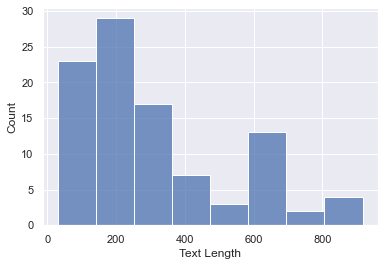

In [23]:
sns.histplot(data = gen_sun_t04, x='Text Length')

In [24]:
gen_sun_t07=getGenDf('Generated Text/sun1_gentext_temp7.txt', 'The Sun', 0.7)
gen_sun_t07

Temperature Publication  \
0           0.7     The Sun   
1           0.7     The Sun   
2           0.7     The Sun   
3           0.7     The Sun   
4           0.7     The Sun   
..          ...         ...   
95          0.7     The Sun   
96          0.7     The Sun   
97          0.7     The Sun   
98          0.7     The Sun   
99          0.7     The Sun   

                                                 Text  Text Length  
0   BORIS Johnson told Emmanuel Macron to "get a g...        384.0  
1   WHITEHALL chiefs have rebuked civil servants f...        305.0  
2   BORIS Johnson will today hand 800,000 doses of...        190.0  
3   BORIS Johnson's hopes of getting all schools b...        214.0  
4   BORIS Johnson told Joe Biden his election as U...        274.0  
..                                                ...          ...  
95  BORIS Johnson will today hand 800,000 doses of...        190.0  
96  BORIS Johnson and Carrie Symonds will "celebra...        300.0  
97  BORIS Johnson will today hand 800,000 doses of...        170.0  
98  SIR Keir Starmer will today warn that tough lo...         96.0  
99  BORIS Johnson and Carrie Symonds will "celebra...        825.0  

[100 rows x 4 columns]

<AxesSubplot:xlabel='Text Length', ylabel='Count'>

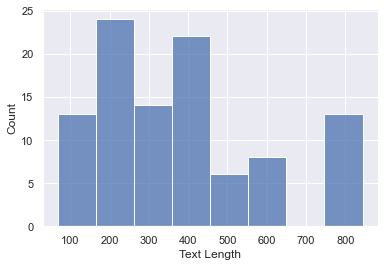

In [25]:
sns.histplot(data = gen_sun_t07, x='Text Length')

In [26]:
gen_sun_t10=getGenDf('Generated Text/sun1_gentext_temp10.txt', 'The Sun', 1.0)
gen_sun_t10

Temperature Publication  \
0           1.0     The Sun   
1           1.0     The Sun   
2           1.0     The Sun   
3           1.0     The Sun   
4           1.0     The Sun   
..          ...         ...   
93          1.0     The Sun   
94          1.0     The Sun   
95          1.0     The Sun   
96          1.0     The Sun   
97          1.0     The Sun   

                                                 Text  Text Length  
0   SIR Keir Starmer  should release his UK with h...         91.0  
1   CABINET ministers are calling for the head of ...        180.0  
2   BORIS Johnson's government appeared to chide N...        101.0  
3   PLANS to convince farmers to hike food stamp b...         61.0  
4   HIKING fuel duty would be a hammer blow to "no...        395.0  
..                                                ...          ...  
93  DOMINIC Cummings' boast to have been cleared f...        439.0  
94  BORIS Johnson today unveiled a massive raid on...        178.0  
95  DOMINIC Cummings' boast to have been cleared f...        188.0  
96  CRUEL domestic abusers who threaten to publish...        307.0  
97  BORIS Johnson has been warned Sinn Fein will s...        241.0  

[98 rows x 4 columns]

<AxesSubplot:xlabel='Text Length', ylabel='Count'>

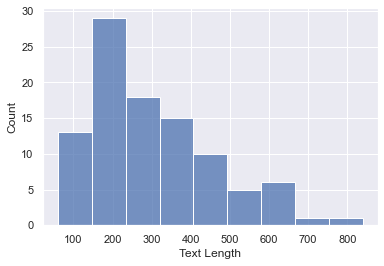

In [27]:
sns.histplot(data = gen_sun_t10, x='Text Length')

In [28]:
sun_gen_full = pd.concat([gen_sun_t04, gen_sun_t07, gen_sun_t10], ignore_index=True)
sun_gen_full.insert(0, 'Type', 'Generated')
sun_gen_full

Type  Temperature Publication  \
0    Generated          0.4     The Sun   
1    Generated          0.4     The Sun   
2    Generated          0.4     The Sun   
3    Generated          0.4     The Sun   
4    Generated          0.4     The Sun   
..         ...          ...         ...   
291  Generated          1.0     The Sun   
292  Generated          1.0     The Sun   
293  Generated          1.0     The Sun   
294  Generated          1.0     The Sun   
295  Generated          1.0     The Sun   

                                                  Text  Text Length  
0    ICAL killer Nicola Sturgeon must learn to live...        109.0  
1    ICAL killer Joe Biden has hit out at his forme...        459.0  
2    ICAL swerved help to avoid a shutdown over the...        238.0  
3    ICAL killer Boris Johnson has been warned he i...        650.0  
4    ICAL killer Boris Johnson has been warned he i...        650.0  
..                                                 ...          ...  
291  DOMINIC Cummings' boast to have been cleared f...        439.0  
292  BORIS Johnson today unveiled a massive raid on...        178.0  
293  DOMINIC Cummings' boast to have been cleared f...        188.0  
294  CRUEL domestic abusers who threaten to publish...        307.0  
295  BORIS Johnson has been warned Sinn Fein will s...        241.0  

[296 rows x 5 columns]

Let's see how text length varies by temperature:

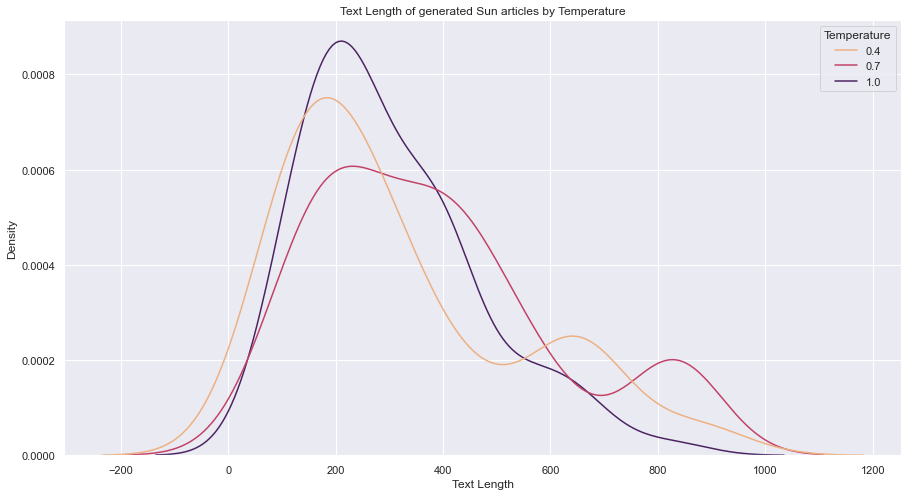

In [29]:
plt.gcf().set_size_inches(15, 8)
ax = sns.kdeplot(data = sun_gen_full, x='Text Length', hue='Temperature', palette='flare', legend=True)
ax.set(title='Text Length of generated Sun articles by Temperature')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18

Compared to the real articles:

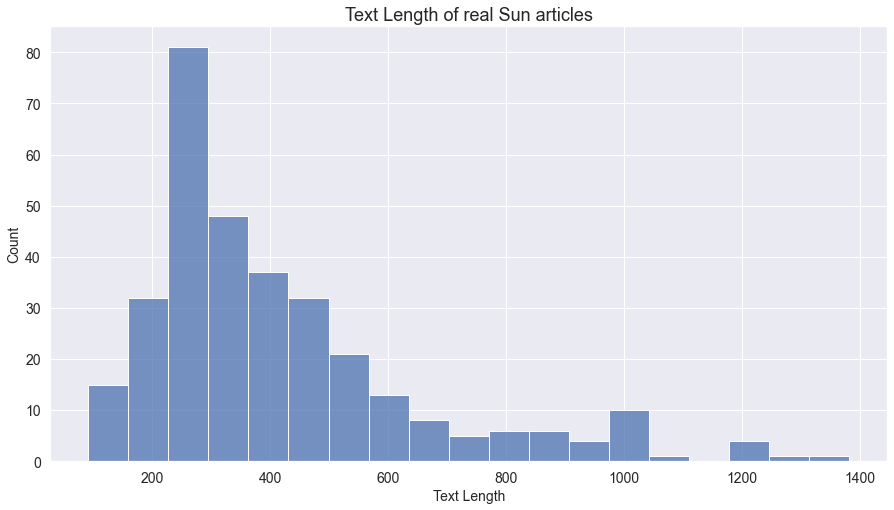

In [30]:
plt.gcf().set_size_inches(15, 8)
ax = sns.histplot(data = sun_real, x='Text Length', palette='flare')
ax.set(title='Text Length of real Sun articles')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18

We can see that while using temperature=1.0 seems to get closest to the real article text length distribition, as a whole generated articles are shorter than real ones.

### 5.4.2 Discussion about generated text

We can already see there are some particular features of our generated text:

* Especially when temperature is a low value, the model appears to often generate the same first word
* The fact the maximum number of tokens you can generate is 1023 has caused an upper word limit which does not match the maximum length of our real articles
* Length of articles seems to generally become more representative with temperature

Before we proceeed with our analysis of style, we need to decide which articles we should use in the analysis and how we are going to deal with the following issues:

1. Repetative generated content 
2. Content which copies too much from real articles
3. The fact that the maximum number of tokens which can be generated at once is smaller than the maximum number of words which articles have

#### Issue 1: repetative generated content

From just looking at a sample of the first words of generated articles, we can see an issue emerge: near identical starts. For example:

In [49]:
gen_sun_t04

Temperature Publication  \
0           0.4     The Sun   
1           0.4     The Sun   
2           0.4     The Sun   
3           0.4     The Sun   
4           0.4     The Sun   
..          ...         ...   
93          0.4     The Sun   
94          0.4     The Sun   
95          0.4     The Sun   
96          0.4     The Sun   
97          0.4     The Sun   

                                                 Text  Text Length  
0   ICAL killer Nicola Sturgeon must learn to live...        109.0  
1   ICAL killer Joe Biden has hit out at his forme...        459.0  
2   ICAL swerved help to avoid a shutdown over the...        238.0  
3   ICAL killer Boris Johnson has been warned he i...        650.0  
4   ICAL killer Boris Johnson has been warned he i...        650.0  
..                                                ...          ...  
93   FOUR in five people think the new TV Licence ...        117.0  
94  ICAL killer Chris Whitty has been found out. T...        130.0  
95  ICAL killer Chris Whitty has been forced into ...        228.0  
96  ICAL murderer Dilyn Foyle has been found guilt...        220.0  
97   The new Foreign Secretary hopes to be a "fant...         70.0  

[98 rows x 4 columns]

This appears to happen less frequently with higher temperatures:

In [50]:
gen_sun_t10

Temperature Publication  \
0           1.0     The Sun   
1           1.0     The Sun   
2           1.0     The Sun   
3           1.0     The Sun   
4           1.0     The Sun   
..          ...         ...   
93          1.0     The Sun   
94          1.0     The Sun   
95          1.0     The Sun   
96          1.0     The Sun   
97          1.0     The Sun   

                                                 Text  Text Length  
0   SIR Keir Starmer  should release his UK with h...         91.0  
1   CABINET ministers are calling for the head of ...        180.0  
2   BORIS Johnson's government appeared to chide N...        101.0  
3   PLANS to convince farmers to hike food stamp b...         61.0  
4   HIKING fuel duty would be a hammer blow to "no...        395.0  
..                                                ...          ...  
93  DOMINIC Cummings' boast to have been cleared f...        439.0  
94  BORIS Johnson today unveiled a massive raid on...        178.0  
95  DOMINIC Cummings' boast to have been cleared f...        188.0  
96  CRUEL domestic abusers who threaten to publish...        307.0  
97  BORIS Johnson has been warned Sinn Fein will s...        241.0  

[98 rows x 4 columns]

Let's investigate how often the first word varies by temperature. For this we will use the `getNumUniqueFirstWords` function which prints the total number of unique first words given a dataframe of articles.

##### The Sun

In [51]:
getNumUniqueFirstWords(gen_sun_t04)

8


In [52]:
getNumUniqueFirstWords(gen_sun_t07)

22


In [53]:
getNumUniqueFirstWords(gen_sun_t10)

46


##### The Mirror

In [54]:
getNumUniqueFirstWords(gen_mirror_t04)

7


In [55]:
getNumUniqueFirstWords(gen_mirror_t07)

18


In [56]:
getNumUniqueFirstWords(gen_mirror_t10)

51


##### The Guardian

In [57]:
getNumUniqueFirstWords(gen_guardian_t04)

15


In [58]:
getNumUniqueFirstWords(gen_guardian_t07)

30


In [59]:
getNumUniqueFirstWords(gen_guardian_t10)

62


We can see that for all the publications, a higher temperature gives us significantly greater diversity in our first words (and presumably, in the rest of the text). We also saw that using a higher temperature parameter for generating text generally gave us a text length distribition which was more represenative of real article text lengths. Using text generated at a lower temperature parameter would likely mean analysing articles which are relatively repetative (and therefore give very similar results). Therefore we will go forward using only the highest temperature (1.0) articles in our analysis.

#### Issue 2: content which copies too much from real articles 

Early on in my experiments generating text, GPT-2 generated the sentence "Boris Johnson says ‘there’s nothing wrong with being woke’", which I later discovered was directly copied from the Sun corpus.

There is a risk GPT-2 will directly copy whole sentences from the corpus it was fine-tuned on (this is more prevelent when working with a low temperature for text generation), which would skew any results in terms of investigating writing style. If there were too many copied sentences, by making GPT-2 look like it is better at replicating writing style than it is. Therefore, we want to check for any generated text which is too similar to real text.

This raises the question: what is *too similar*? I decided a good way to calculate what a 'suspiciously high similarity' metric is would be by comparing the articles within a publication corpus to each other to see how similar they are. We would do this by giving each pair of articles a similarity score, and then looking at the distribution of similarity scores. 

In this function, I use the `pysimilar` package, which allows us to get a cosine similarity score (0 = not similar at all, 1 = exactly the same) through one command: `compare(text1, text2)`. `pysimilar` works like so: 'It uses Tfidf Vectorizer to transform the text into vectors and then obtained vectors are converted into arrays of numbers and then finally cosine similary computation is employed resulting to output indicating how similar they are.' Cosine is a good metric of similarity to use in this case because it looks at similarity irregardless of size of text being compared, which is appropriate as all our articles are different lengths.

In [60]:
def checkTextSimilaritySelf(df):
    allscores = []
    for i in df.index:
        
        text1 = df['Text'][i]
        
        for a in df.index:
            
            if i < a:
            
                text2 = df['Text'][a]

                score = compare(text1, text2)
                allscores.append(score)
    
    return allscores

##### Looking at distribution of similarity within corpora of real articles

The Sun:

In [550]:
sun_similarities = checkTextSimilaritySelf(sun_real)

In [551]:
max(sun_similarities)

0.9798441510297389

<AxesSubplot:ylabel='Count'>

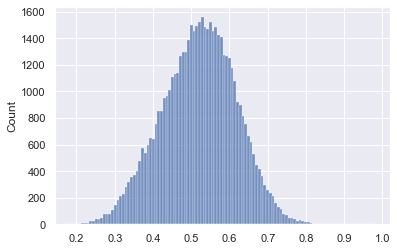

In [552]:
sns.histplot(sun_similarities)

The Mirror:

In [553]:
mirror_similarities = checkTextSimilaritySelf(mirror_real)

In [555]:
max(mirror_similarities)

0.9030725498394568

<AxesSubplot:ylabel='Count'>

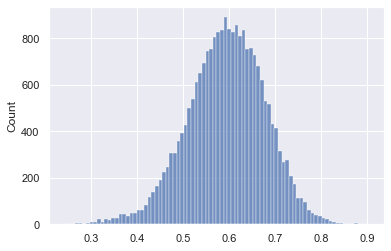

In [556]:
sns.histplot(mirror_similarities)

The Guardian:

In [554]:
guardian_similarities = checkTextSimilaritySelf(guardian_real)

In [557]:
max(guardian_similarities)

0.9153338922958373

<AxesSubplot:ylabel='Count'>

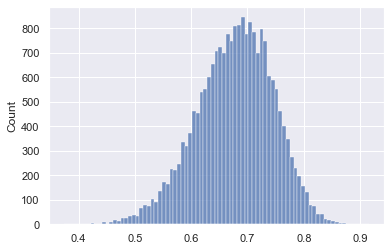

In [558]:
sns.histplot(guardian_similarities)

We can see some very interesting results here! Most articles within a corpora have a pretty high cosine similarity to each other, even past the 0.9 mark. We even saw that two sun articles had a similarity score of 0.98! This means we only really need to be concerned if generated articles have a similarity score of greater than 0.90 to a real article.

##### Identifying generated articles with very high similarity scores to real articles

The function below calculates the cosine similarity score between each generated article in a generated article corpus and each real article in a real article corpus. If the score is greater than a certain number - which we decided above should be 0.90 - it will print out the score and the articles so we can assess them. We saw above that given real articles can have a similarity score of up to 0.98, similarity is not an indication of direct copying - it could simply be the case that many of the same words are present.

In [580]:
def checkTextSimilarity(gen_df, real_df):
    high_similarities = []
    for i in gen_df.index:
        gen_text = gen_df['Text'][i]
        
        for a in real_df.index:
            real_text = real_df['Text'][a]
            
            score = compare(gen_text, real_text)
            if score > 0.90:
                print('Generated article', i, 'has a high similarity to real article', a, 'with a score of', score)
                print()
                print('Generated article:', gen_text)
                print()
                print('Real article:', real_text)
                print()
                print()
                high_similarities.append(i)
            
    if len(high_similarities) > 0:
        print('Generated articles with highly similarities:', set(high_similarities))

The Sun:

In [581]:
checkTextSimilarity(gen_sun_t10, sun_real)

Generated article 7 has a high similarity to real article 584 with a score of 0.966319908632123

Generated article: HORNY jailbirds spent £25,000 on sex chatlines — and landed the Ministry of Justice with the bill. Mobiles given to prisoners on probation were blocked from making premium-rate calls. But a handful of canny inmates worked out that you could request a call back by text — effectively reversing the charges — and the taxpayer was left to pick up the tab. Nine lags spent more than £2,000 each on the scam, despite the phone provider assuring MoJ chiefs the devices were secure. Furious ministers had to cut a deal with the network to claw back the cash. The ruse came about when, as part of special measures relating to coronavirus, thousands of prisoners were let out on licence. They were given basic mobiles that could only receive incoming calls while they were on the outside. But officials were baffled when they were slapped with a mega invoice for their use. A government source

Generated article 24 has a high similarity to real article 257 with a score of 0.9999999999999999

Generated article: DOMINIC Cummings' boast to have been cleared from leaking lockdown secrets was not backed up by Britain's top civil servant - and spies hunting the "chatty rat" may never get their man. Cabinet Secretary Simon Case also tore up Cummings' incendiary blog claims Boris had suppressed a probe into last year's leak to protect a pal of his fiancee Carrie Symonds. Hauled before MPs to explain why no one has been caught five months after the planned November lockdown was leaked early, the newbie mandarin insisted that one had yet been found guilty or cleared. But the head of the civil service was forced to admit the "source or sources" may never be found, despite top secret intelligence agency work trying to track them down for months. However Case all but confirmed the security services had been brought into probe the leak, but he admitted no criminal activity or breach of the

Generated article 34 has a high similarity to real article 311 with a score of 0.9857370695865928

Generated article: WEMBLEY will be stuffed with "as many people as we can" for the Euros final, Britain's sports boss has confirmed for the first time. Culture Secretary Oliver Dowden says he is "confident" this can happen with "less or no social distancing" thanks to "Covid certification". And he reiterated that Britain stands ready to host more European Championship matches and is waiting for organiser UEFA's call. The football tournament's semi-finals and final are already pencilled in for Wembley in July with other other other matches spread over Europe. But thanks to the UK's gangbusters vaccine rollout and soaring Covid cases on the Continent, Britain is offering to host more games. In an interview with The Sun, Mr Dowden said: "We are working to make sure we can get as many people as we can into the final and the semis and deal with all the other challenges around that. In terms of

Generated article 40 has a high similarity to real article 225 with a score of 0.9619574975288199

Generated article: BORIS Johnson and Carrie Symonds will "celebrate their wedding" next summer, The Sun can reveal. The Prime Minister, 56, and his fiancée, 33, have sent save-the-date cards to family and friends for a lavish bash on Saturday, July 30, 2022. The couple got engaged in late 2019 but, like thousands of other loved-up Brits, have had to delay plans because of Covid. Details of exactly where the couple will say "I do" remain a closely guarded secret, but pals say they are waiting until next year for a big celebration to be on the safe side. BoJo is expected to announce that the lockdown cap of 30 guests at weddings will be lifted next month. However, friends of the couple say the fight against the virus, and getting the country bouncing back from the pandemic, means this summer is too soon for their big knees-up. Early contenders as a location for the party include the PM's co

Generated article 57 has a high similarity to real article 393 with a score of 0.9994028576480305

Generated article: BORIS Johnson's government appeared to chide Nicola Sturgeon for letting the side down with Scotland's slow vaccination pace last night. And ministers offered to help "accelerate" the pace north of the border with more resources from the UK government - in a move that risked infuriating the nationalists. As the UK hit the ten million jabs mark, the Westminster government wrote to the SNP boss to say "it is in everyone's interests that progress in vaccinating the people of Scotland matches the best efforts of the rest of UK". Scottish Secretary Alister Jack added: "With that in mind, we stand ready to offer any support or assistance we can give you to accelerate your rollout programme." Of the 4.4million adults in Scotland to be vaccinated, so far 610,778 have received the first jab. However Ms Sturgeon accepted that her government did want to "accelerate the overall pro

Generated article 63 has a high similarity to real article 608 with a score of 1.0000000000000004

Generated article: ANGRY Boris Johnson had to pack up his tent and come home after his Scottish holiday location was leaked, The Sun can reveal. The PM had taken fiancée Carrie Symonds and new baby Wilfred for a break after a traumatic six months. It was his first getaway since the start of the coronavirus pandemic which saw him fall seriously ill with Covid-19 shortly before his son's birth at the end of April. But the windswept location was leaked when photos of his secluded Highland cottage and tent were published. Bodyguards said it wasn't safe for the family to stay on and it is understood they flew home on Thursday after just three days. A well placed source said: "They had been camping in the garden of the cottage but the security threat was too much. "The tent could be spotted by a sniper from too far away for them to stay after the location was published." Pictures showed a teepe

Generated article 71 has a high similarity to real article 386 with a score of 0.9328658267181045

Generated article: BORIS Johnson and Dominic Raab must "come absolutely clean" about when they learnt the killer of Harry Dunn was a secret US spy, the dead teenager's family have demanded. Lawyers representing American mum-of-three Anne Sacoolas sensationally admitted in a US Court that she was a intelligence agent. Sacoolas fled Britain after a fatal smash with the 19 year old motorcyclist outside RAF Croughton, Northamptonshire in August 2019. She was driving on the wrong side of the road but claimed diplomatic immunity as her husband worked at the US spy base. But on Wednesday night,  the Alexandria district court in Virginia was told Anne Sacoolas was "employed by an intelligence agency in the US" at the time of the fatal  collision - which was "especially a factor" in her flight from the UK. Her lawyer said she fled the country due to "life-changing circumstances". The Sun understan

Generated article 75 has a high similarity to real article 335 with a score of 0.9999999999999998

Generated article: RISHI Sunak's Budget was welcomed by Brits last night with more people thinking the policies announced were a good idea than bad, snap polling for The Sun showed. Pollsters Opinium found 52 per cent approve of the budget with 12 per cent disapproving – a net score of a whopping +40. And even controversial hikes to corporation tax and the freezing of income tax allowances were backed. 51 per cent thought the Budget was fair, with just 19 per cent thinking it is unfair. But less than one in five thought they would feel any positive effect on their household finances. 41 per cent approve of the way the government are handling the economy, compared to 35 per cent who disapprove – a net score of +6. Boris and Rishi have a 14 point lead when it comes to who the public most trust to run the nation's finances. But 64 per cent are worried about the state of the economy, an 44 pe

Generated article 83 has a high similarity to real article 463 with a score of 0.9719303672629971

Generated article: MINISTERS will begin the abolition of cruel live animal shipments tomorrow — a ban only made possible by Brexit. Under strict European Union Single Market rules that guarantee free movement of goods, no member state can ban livestock being transported across borders alive. But with Britain finally cutting ties with Brussels in 39 days time, the controversial process will be outlawed to the delight of campaigners. Boris Johnson has repeatedly vowed to use the "the opportunity of Brexit" to "champion animal welfare" and will unveil plans for new legislation on Thursday. In 2018 Mr Johnson hit out: "I cannot believe that this barbaric trade is still going on — but it is. Every year this country sends thousands of live calves overseas for slaughter, and some of them are enduring nightmare journeys as far as North Africa. "They are jammed together in the dark. They are terri

Generated article 86 has a high similarity to real article 328 with a score of 0.9408531217034832

Generated article: BORIS Johnson defended the 1% pay hike offer to nurses insisting he had "tried to give them as much as we can." But the government could yet u-turn on to to see off a strike, Gavin Williamson hinted. The Education Secretary said the offer was "part of a process" but added "no one wants to see a industrial action." Mr Williamson stressed NHS workers the only part of the public sector to see any rise this year because of a "period of restraint" sparked by £407 billion of pandemic spending. Mr Williamson said on Sunday morning TV that that the Department of Health had "put forward what we believe we can afford" for nurses during "difficult economic challenges". He stressed teachers and others in the public sector will face a pay freeze, with NHS staff the only group to be exempted following their efforts during the crisis. Speaking on a visit to a vaccine hub in Northwest 

Generated article 93 has a high similarity to real article 257 with a score of 0.9131178891126237

Generated article: DOMINIC Cummings' boast to have been cleared from leaking lockdown secrets was not backed up by Britain's top civil servant - and spies hunting the "chatty rat" may never get their man. Cabinet Secretary Simon Case also tore up Cummings' incendiary blog claims Boris had suppressed a probe into last year's leak to protect a pal of his fiancee Carrie Symonds. Hauled before MPs to explain why no one has been caught five months after the planned November lockdown was leaked early, the newbie mandarin insisted that one had yet been found guilty or cleared. But the head of the civil service was forced to admit the "source or sources" may never be found, despite top secret intelligence agency work trying to track them down for months. However Case all but confirmed the security services had been brought into probe the leak, but he admitted no criminal activity or breach of the

We can see that these pieces of generated text have a high degree of copying behaviour, so we will drop them from our corpus.

In [62]:
sun_gen = gen_sun_t10.drop([7, 8, 22, 24, 25, 34, 37, 40, 57, 59, 63, 66, 71, 72, 75, 76, 79, 83, 86, 87, 93])

*The above exercise was repeated for The Mirror and The Guardian, code has been removed in the portfolio version for the sake of brevity.*

Earlier we saw that often (although less frequently in text generated with a higher temperature parameter) generated text began with the same word (and probably carried on with much of the same content). To reduce repetition, and therefore results being skewed by a few repetitive types of output, let's reduce our generated dataset to only articles which have unique starting words. We stated earlier than we need at least 30 articles to be able to use z-tests in our analysis. Let's investigate how many unique first words our generated text corpora now have:

In [65]:
getNumUniqueFirstWords(sun_gen)

41


In [66]:
getNumUniqueFirstWords(mirror_gen)

50


In [67]:
getNumUniqueFirstWords(guardian_gen)

60


This is sufficent. The `uniqueFirstWords` function will drop any articles whose first word is a repetition, returning a dataframe with articles with unique first words:

In [68]:
sun_gen = uniqueFirstWords(sun_gen)

In [69]:
mirror_gen = uniqueFirstWords(mirror_gen)

In [70]:
guardian_gen = uniqueFirstWords(guardian_gen)

Before we create our final datasets of generated data, let's check none of the articles are *too* crazy (i.e. different language, strange symbols):

In [71]:
for i in sun_gen.index:
    print('Article:', i)
    print(sun_gen['Text'][i])
    print()

Article: 0
SIR Keir Starmer  should release his UK with his own people Christmas cards. The ex-Labour leader and increasingly left-wing President will, to kick-start his second plan, lay out in writing his plan to avoid UK isolation what he thinks are "the rules nine to five" problems when it comes to over-entering the restricted overspotting scheme. He will also outline how to get around the restrictions in the Race Course to avoid jail if necessary. Most of the extra restrictions will be eased over the next three years under Mr Johnson's plans.

Article: 1
CABINET ministers are calling for the head of Rishi Sunak's chief aide as spies, The Sun can reveal. The Cabinet Office (Co-operation) first approached the pair just days ago to approve the use of a Surgical Positioning Radioper General Positioner. But the pair's relationship deteriorated into a bitter Cold War after the aide's ex-mentor slammed the Prime Minister's())im communications director. Simon Case criticised the style of g

In [72]:
for i in mirror_gen.index:
    print('Article:', i)
    print(mirror_gen['Text'][i])
    print()

Article: 0
 - Labour should prioritise the well-being of pupils - not the lobbyists or the special-interests -- and iselman suggested they should focus on the children's wellbeing Instead of taxing families to clear the NHS up to the private sector, we should be focusing our efforts on helping our children to recover from the pandemic instead of taxing them to pay for it. Jonathan.smith@ft.com.uk

Article: 1
 Education Secretary Nadhim Zahawi said he did not want a new curriculum either but accepted that pupils should continue to learn the rules of the classroom   Nagpaul, the Education Secretary, denied last week that there was still time to update the standards after more than a decade of Tory austerity. The Tory peer announced he was giving every adult a chance to learn the rules of the street in their constituency, even though that would be "disastrous" for schools. Mr Zahawi said this week that schools should be able to request that disruptive behaviour be banned although that wou

In [73]:
for i in guardian_gen.index:
    print('Article:', i)
    print(guardian_gen['Text'][i].strip())
    print()

Article: 0
Last week's budget included a stealth cut to funding for youth services worth more than £400m over the next three years, Labour has claimed. The shadow schools minister, Vicky Foxcroft, said: "Cuts are necessary to support school run-downs and the recovery from the pandemic. "Young people are still getting thrown into the biggest surge in school-age dependency in more than a decade, and there is pressure from across the political spectrum to trim the curriculum. The right thing is for the government to act now, and to accept the budget and act on it today." In his budget speech last Wednesday, the chancellor said he would create "poverty pay" that would cover the rising costs of farming and other sectors. Pledging to make sure "we don't have to switch economies", the chancellor said: "When we bring jobs back, we'll have enough money to feed the economy and save the families who have worked so hard over the pandemic. We can't have enough of working, and we can't have enough o

The Sun and Mirror generated text appears mostly fine at brief glance (although some could only very loosely be said to represent news articles). The Guardian has numerous issues with continuous lengths of punctuation and random foreign letters. As we will be cutting down the generated corpora anyway, we can drop these articles as they may potentially cause us problems during analysis.

In [74]:
guardian_gen.drop([6, 12, 18, 21, 28, 37, 49, 55, 83], inplace = True)

As we will be cutting down the datasets to a smaller number of records anyway, at this stage we will also drop articles with problematic features such as emails within the text (this will skew sentence length - although it is possible to code around this, for ease we will drop these records):

In [75]:
sun_gen.drop([3], inplace = True)

In [76]:
mirror_gen.drop([0, 60, 72], inplace = True)

Finally, we want to cut down our generated corpora to the same number of articles. The sun_gen dataframe currently has 41 entries, so let's make each dataframe of generated articles a round 40:

In [77]:
sun_gen = sun_gen[:40]

sun_gen.reset_index(inplace = True, drop = True)
sun_gen

Temperature Publication  \
0           1.0     The Sun   
1           1.0     The Sun   
2           1.0     The Sun   
3           1.0     The Sun   
4           1.0     The Sun   
5           1.0     The Sun   
6           1.0     The Sun   
7           1.0     The Sun   
8           1.0     The Sun   
9           1.0     The Sun   
10          1.0     The Sun   
11          1.0     The Sun   
12          1.0     The Sun   
13          1.0     The Sun   
14          1.0     The Sun   
15          1.0     The Sun   
16          1.0     The Sun   
17          1.0     The Sun   
18          1.0     The Sun   
19          1.0     The Sun   
20          1.0     The Sun   
21          1.0     The Sun   
22          1.0     The Sun   
23          1.0     The Sun   
24          1.0     The Sun   
25          1.0     The Sun   
26          1.0     The Sun   
27          1.0     The Sun   
28          1.0     The Sun   
29          1.0     The Sun   
30          1.0     The Sun   
31          1.0     The Sun   
32          1.0     The Sun   
33          1.0     The Sun   
34          1.0     The Sun   
35          1.0     The Sun   
36          1.0     The Sun   
37          1.0     The Sun   
38          1.0     The Sun   
39          1.0     The Sun   

                                                 Text  Text Length  
0   SIR Keir Starmer  should release his UK with h...         91.0  
1   CABINET ministers are calling for the head of ...        180.0  
2   BORIS Johnson's government appeared to chide N...        101.0  
3   HIKING fuel duty would be a hammer blow to "no...        395.0  
4   FEARS are growing that Swindon could be the ne...        281.0  
5   NEARLY five million Brits have been let out of...        114.0  
6   BRITAIN is being run like a "tin-pot dictators...        348.0  
7   FINES must be relaxed for the summer holidays ...        109.0  
8   LIZ Truss does not recognise her ex-butt-faggo...        173.0  
9   SENIOR ministers and Royals are set to snub th...        178.0  
10  DRIVERS facing a sudden emergency in their vit...        529.0  
11  REBELS facing a fresh Boris Johnson threat str...        385.0  
12  LONDON health chiefs are on standby to start t...        381.0  
13  A BUDGET brings home millions and drives home ...        218.0  
14  JUST 607 Criminal Behaviour Orders were slappe...        137.0  
15  HEALTH chiefs are under pressure not to hike n...        192.0  
16  FRANCE'S Emmanuel Macron has pinched Boris Joh...        557.0  
17  FLIP-flopping Sir Keir Starmer was accused of ...        212.0  
18  MATT Hancock will put on a protective mask to ...        396.0  
19  TWO sex crimes bosses want to replace punters ...        160.0  
20  BRITS face yet another uncertain Christmas ami...        426.0  
21  COUNCIL ministers are calling for the head of ...        183.0  
22  ARMY drivers have started delivering fuel toda...        167.0  
23  THE Chequers gang rape trial will be a ' water...        188.0  
24  EMERGENCY plans have been drawn up to protect ...        278.0  
25  WE have all been told that Christmas is now. A...        184.0  
26  POLITICIANS, trade unions and some of Britain'...        269.0  
27  HOLIDAYS to America will be open to double- ja...        225.0  
28  DOUBLE jabbed mums and dads will be able to ta...        270.0  
29  RISHI Sunak has unveiled his new top dog Nova....        419.0  
30  CRUEL nationals — and abused asylum seekers in...        189.0  
31  PUTTING UP Fuel Duty at next week's Budget wou...        529.0  
32  BURGLARS and thieves will be electronically ta...        229.0  
33  BREXIT Britain is ripening its defences to the...        193.0  
34  THERESA May could make a shock return to front...        121.0  
35  DOMINIC Cummings' boast to have been cleared f...        582.0  
36  ISLAMIC State remains a "potent" threat to Bri...        133.0  
37  PRITI Patel is the red herring in Britain's Br...        330.0  
38  FAMILIES will be told they must start

*The above exercise was repeated for The Mirror and The Guardian, code has been removed in the portfolio version for the sake of brevity.*

#### Issue 3: limit on maximum number of tokens which can be generated at once

There is a token limit of 1023 for generating articles for GPT-2. Unfortunately, this was a fact I only discovered after fine-tuning my models and generating articles.

Comparing real articles with generated articles with a much shorter word limit creates some issues in terms of investigating style as we may get skewed results. There are a few options to address this issue:
1. Retrain GPT-2 on new corpora with only articles which have a word count of up to the token generation maximum
2. For generated articles which hit the token limit, generate additional text to append onto the article using the last sentence as the generation prefix instead of <|startofarticle|>
3. Drop any articles longer than the token generation limit
4. Cut longer articles down to the token generation limit

While option 1 and 2 are probably the most ideal solution, in this case they would require a significant new time investment, and due to time constraints, would limit progress on the rest of the project. Therefore these options were ruled out.

I decided to go for option 4 because this should then in essence replicate the distribution we saw with generated article lengths: a peak of articles at around 800-1000 words, which we can think of as articles which would have been longer if it wasn't for the word limit. Hopefully this will create as much similarity as possible between the generated and real datasets, and make our findings as valid as possible.

We have to be mindful that what GPT-2 considers tokens is probablt somewhat different to our word count. Let's have a look at our maximum word counts for our generated text:

In [80]:
max(sun_gen['Text Length'])

656.0

In [81]:
max(mirror_gen['Text Length'])

876.0

In [82]:
max(guardian_gen['Text Length'])

853.0

We can see the maximum word length of any generated article is 876, so for consistency, let's cut all our real articles down to this length. First let's combine all our real articles into one dataframe:

In [83]:
real = pd.concat([sun_real, mirror_real, guardian_real], ignore_index=True)
real.insert(0, 'Type', 'Real')
real

Type  URL_ID   Publication          Authors  \
0    Real       1       The Sun       Harry Cole   
1    Real       8       The Sun       Harry Cole   
2    Real       9       The Sun       Harry Cole   
3    Real      14       The Sun       Harry Cole   
4    Real      15       The Sun       Harry Cole   
..    ...     ...           ...              ...   
740  Real     468  The Guardian  Heather Stewart   
741  Real     471  The Guardian  Heather Stewart   
742  Real     475  The Guardian  Heather Stewart   
743  Real     477  The Guardian  Heather Stewart   
744  Real     478  The Guardian  Heather Stewart   

                                                 Title  \
0    Migrants could be electronically tagged to det...   
1    Boris Johnson warned by MPs he is drinking in ...   
2    No10 probe into Christmas lockdown parties col...   
3    Pubs and restaurants could be CLOSED or have e...   
4    Five new Tory MPs have demanded scandal-hit Bo...   
..                                                 ...   
740  Boris Johnson says Brexit deal has settled UK'...   
741  PM announces 'tier 4' Covid curbs and curtails...   
742  Boris Johnson wanted a leak-free regime. That ...   
743  Labour MPs sign letter urging Starmer to resto...   
744  Labour to appoint Jewish board to help draw up...   

                                                  Text  Text Length  \
0    CHANNEL migrants could be electronically tagge...          367   
1    PM Boris Johnson has been warned he is drinkin...          649   
2    DOWNING Street's probe into Christmas lockdown...          343   
3    MISERABLE Whitehall officials have drawn up pl...          579   
4    BORIS Johnson is facing a growing Tory mutiny ...          347   
..                                                 ...          ...   
740  Boris Johnson claimed finally to have settled ...          595   
741  Boris Johnson has issued a new "stay at home" ...          738   
742  When Boris Johnson's cabinet met by video link...          489   
743  Leftwing Labour MPs, union leaders and activis...          629   
744  Labour will appoint a Jewish advisory board to...          602   

     Title Length  
0              11  
1              15  
2              19  
3              20  
4              12  
..            ...  
740            10  
741            12  
742            12  
743            11  
744            12  

[745 rows x 8 columns]

Now we can cut down the articles to the 876 token cap:

In [84]:
for i in real.index:
    text_lst = real['Text'][i].split(' ')
        
    if len(text_lst) > 876:
        new_text = ' '.join(text_lst[:876])
            
        real.loc[i,['Text']] = new_text
        real.loc[i,['Text Length']] = 876

We can now see all our real articles have been capped at 876:

In [85]:
max(real['Text Length'])

876

### 5.4.3 Text clean up

We will be looking at sentences in our stylistic analysis, so we want to make sure we have whole ones. Some sentences in both real and generated corpora will now be cut off at the word limit. In addition, some of the generated texts have a <|startofarticle|> marker at the beginning (GPT-2 having generated two in a row), so we will want to clear those up also.

First let's combine all our generated articles into one dataframe:

In [86]:
gen = pd.concat([sun_gen, mirror_gen, guardian_gen], ignore_index=True)
gen.insert(0, 'Type', 'Generated')
gen

Type  Temperature   Publication  \
0    Generated          1.0       The Sun   
1    Generated          1.0       The Sun   
2    Generated          1.0       The Sun   
3    Generated          1.0       The Sun   
4    Generated          1.0       The Sun   
..         ...          ...           ...   
115  Generated          1.0  The Guardian   
116  Generated          1.0  The Guardian   
117  Generated          1.0  The Guardian   
118  Generated          1.0  The Guardian   
119  Generated          1.0  The Guardian   

                                                  Text  Text Length  
0    SIR Keir Starmer  should release his UK with h...         91.0  
1    CABINET ministers are calling for the head of ...        180.0  
2    BORIS Johnson's government appeared to chide N...        101.0  
3    HIKING fuel duty would be a hammer blow to "no...        395.0  
4    FEARS are growing that Swindon could be the ne...        281.0  
..                                                 ...          ...  
115   Driven by a campaign promise to create a "gre...        623.0  
116   Travellers to destinations up and down the UK...        123.0  
117   Record breaking days for weekly spent by the ...        222.0  
118   Ashton-under-Lytle has called on the governme...        442.0  
119   Hotels, hostels and villas in Starmer's party...        853.0  

[120 rows x 5 columns]

For both the real and generated datasets we will cut the dataset to the last full stop (or the last two characters being '."', to signify the end of a quote). We will do this using the `cutToLastFS` function which, given a dataframe, cuts down the text of each record down to the last '.' or '."', and updates the text length as needed:

In [87]:
gen['Text Length'].sum()

51790.0

In [88]:
cutToLastFS(gen)
gen['Text Length'].sum()

51231.0

In [89]:
real['Text Length'].sum()

385544

In [90]:
cutToLastFS(real)
real['Text Length'].sum()

383650

In addition, for the generated dataset, there are two more things to clean up: removing any additional <|startofarticle|> markers at the start of the text, and removing any leading spaces (these were not removed earlier in case GPT-2 did not always leave a space between the <|startofarticle|> marker and the first word during generation).

In [91]:
for i in gen.index:
    text_lst = gen['Text'][i].strip().split(' ')
        
    if text_lst[0] == '<|startofarticle|>':
        new_text = ' '.join(text_lst[1:])
            
        gen.loc[i,['Text']] = new_text
        gen.loc[i,['Text Length']] = len(new_text.split())

In [92]:
for i in gen.index:
    gen.loc[i,['Text']] = gen['Text'][i].strip()

Now that our data is finally clean, let's combine the real and generated articles into one dataframe:

In [93]:
art = pd.concat([real, gen], ignore_index=True)
art.drop(['URL_ID', 'Authors', 'Title', 'Title Length', 'Temperature'], axis=1, inplace=True)

art.insert(3, 'Type and Publication', '')

for i in art.index:
    pub = art['Publication'][i]
    atype = art['Type'][i]
    if atype == 'Generated':
        atype = 'Gen'
    art.loc[i, ['Type and Publication']] = atype + ' ' + pub[4:]

In [94]:
#art.to_csv('art.csv')

#art = pd.read_csv('art.csv', index_col=0)

# 6 Investigating stylistic features <a class="anchor" id="sf"></a>

## 6.1 Approach to analysis

When investigating how well GPT-2 generated data replicates the stylistic features of data it was fine-tuned on, there are two questions we may ask:
1. A question of replication: Does generated text replicate the features of the corpora it was fine-tuned on?
2. A question of differentiation: Does generated text tend to have similar features, regardless of the corpora it was fine-tuned on? Or are corpora of generated data clearly differenciated from each other?

In investigating stylistic features, we will do three steps for each area of exploration:
1. Create features as numeric values
2. Visualise data to spot trends and patterns
3. Where appropriate, carry out statistical tests to answer the questions of whether:  
    (a) generated data has the same features as real data  
    (b) generated data for different publications (i.e. from models fine-tuned on different data) have the same features

## 6.2 Statistical tests

For the statistical tests to determine if (statistically speaking) generated data has the same features as real data, we will use the function `statisticalTests` performs the following:

* Part 1: Determining whether the data is normally distributed. Rather than using visual metrics (histrogram, Q-Q plot) to determine whether data is normal for every set of features we create, we can use a statistical test for normality. We will use the Shapiro-Wilk test of normality, at a 95% confidence (i.e. reject '$H_{0}:$ Data is Gaussian' when p-value <= 0.05). 
* Part 2: Carrying out either an independent z-test or a Mann-Whitney U test. If both the real and generated data appear to be normally distributed for the feature we are looking at, we can use a z-test. Otherwise, we will use Mann-Whitney. Both tests are performed at a 95% confidence (i.e. alpha = 0.05).
* There is a parameter for each publication to indicate that the spread of data between real and generated data is significantly different, and therefore even the distributions are Gaussian, we should use the nonparametric test instead as unequal spread violates the assumption of an independent z-test. 
* There is a parameter for each publication to indicate the distribution shapes for real and generated data are significantly different, and therefore no statistical tests can be carried out as an assumption for the Mann-Whitney U test is that the distribution shapes of the data being tested are roughly the same. 
    
If the distributions of a feature appear very similar across publications for generated articles, real articles or both, we can test whether the distributions are the same across all three publications using a one-way ANOVA (parametric) or a Kruskal-Wallis test (non-parametric). Both the `onewayANOVA` and `kruskalWallis` functions perform the statistical test comparing the data from the three different publications for one article type (i.e. real or generated data) at a 95% confidence. `onewayANOVA` first performs Levene's test (at a 95% confidence) to determine whether the variances of the datasets are sufficently similar to perform a one-way ANOVA. If the assumption of homogeneity of variance is violated, a Kruskal-Wallis is performed instead. 

Addressing the assumptions required to carry out statistical tests:

* **Continuous data:** All data measured through the statistical tests will be continuous, which is an assumption of the tests
* **Number of samples:** We have at least 40 samples in each category, which is sufficent to carry out all the statistical tests
* **Independence**: The z-test and Mann-Whitney U test assume independence. Although the real text influences the generated text through training, the samples are still independent in a statistical context. This is because paired tests (the other type of test in contrast to independent tests) assume that the same objects or individuals are being measured *in both samples*. For example, the blood pressure of the same people taken a year apart. In our real and generated datasets, we are measuring entirely seperate entities: we are not taking measurements about the same object, there is no one-to-one link. Therefore we assume independence. 
* **Similar spread:** The z-test assumes a similar spread between groups. Usually variance is used as the measure of spread, however, in this case we will use similar range as a measure of spread, rather than variance (which takes into account number of samples, and therefore would likely create different variance for real and generated groups). The `statisticalTests` function assumes similar spread but includes optional parameters to indicate unequal spread between the real and generated samples for each population. As we will first visually assess the data prior to statistical tests, we will be able to spot if ranges are significantly different for the real and generated data. As we have much more similar dataset sizes within article types (i.e. real and generated), the `onewayANOVA` function does test for homogeneity of variance using Levene's Test. 
* **Shape of distribution:** The Mann-Whitney U test assumes a roughly similar shape of distribution between the two datasets. The `statisticalTests` function assumes this is true, however includes optional parameters to indicate if the distribution shape is significantly different for the real and generated text for a feature, in which case no statistical test will be carried out as the data does not conform to the assumptions required. Significantly differing distribution shapes will be spotted at the visualisation stage.

**Choice of libraries**

The SciPy library is used for Shapiro-Wilk, Mann-Whitney U, Levene's Test, One-Way ANOVA and Kruskal-Wallis. SciPy allows us to run statistical tests with just one function, e.g. `shapiro()`, which is highly efficent in regards to code. It is the dominant python library for running these types of statistical tests. The independent z-test is from the statsmodels library. This library is more commonly used for regression, generalised linear models etc, however it does contain an independent z-test which fit the requirements. The SciPy library only had independent t-tests (which uses a T distribution rather than the Z distribution which should be used when n > 30), and a z-score test (which gives a z-score for every sample in an array, which not what we need). 

**Visualisations**

`typeKDEpub` plots two KDE plots side by side - one for generated text, one for real articles. A KDE plot is used rather than a histogram as it is easier to see the distribution of data on a KDE plot - data becomes obscured on a histogram with more than one category.

Before we begin, let's create colour palettes to use within our visualisations:

In [308]:
# Create a colour palette for graphs where we want to differenciate the three different publications

pub_palette = sns.blend_palette(['goldenrod', 'crimson', 'blue'], 3)

# Create a colour palette for graphs where we want to differenciate type

type_palette = sns.xkcd_palette(['azure', 'cherry red'])

## 6.3 Measures of length
### 6.3.1 Text length

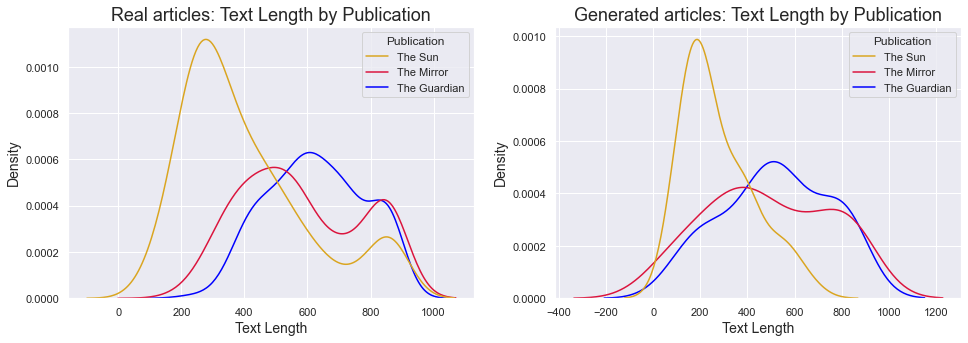

In [28]:
typeKDEpub(art, 'Text Length', 'Text Length')

In [29]:
statisticalTests(art, 'Text Length')

For The Sun data:
Real data is Gaussian: False
Generated data is Gaussian: False 

The Man-Whitney U test p-value is 1.624263054896957e-05
Results of the Man-Whitney U test indicate that Text Length is significantly different between the real and generated text. 

For The Mirror data:
Real data is Gaussian: False
Generated data is Gaussian: False 

The Man-Whitney U test p-value is 0.008045502771674236
Results of the Man-Whitney U test indicate that Text Length is significantly different between the real and generated text. 

For The Guardian data:
Real data is Gaussian: False
Generated data is Gaussian: False 

The Man-Whitney U test p-value is 0.001778156454993174
Results of the Man-Whitney U test indicate that Text Length is significantly different between the real and generated text. 



The models create generate text which is as a whole shorter than real text, however, the shapes of the generated text length distributions do resemble the real article distributions.

### 6.3.2 Average sentence length

Let's calculate average sentence length:

In [82]:
art.insert(len(art.columns), 'Avg Sentence Length', 0)

for i in art.index:
    text_lst = art['Text'][i].split('.')
    
    sent_lens = [len(sentence.split(' ')) for sentence in text_lst]
        
    art.loc[i, ['Avg Sentence Length']] = round(sum(sent_lens)/len(sent_lens), 2)

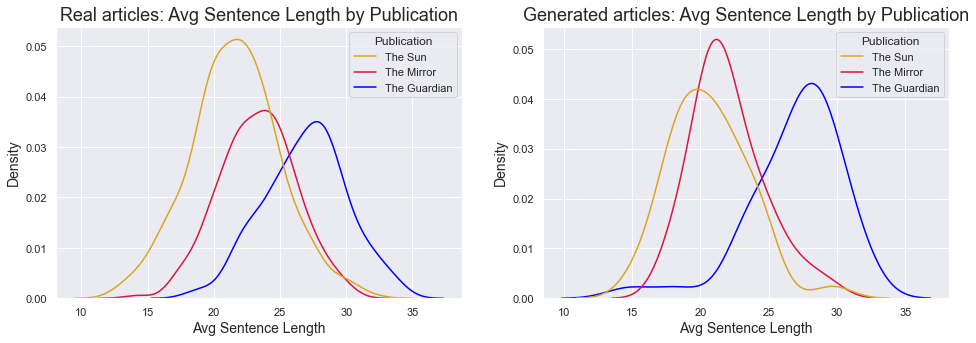

In [31]:
typeKDEpub(art, 'Avg Sentence Length', 'Avg Sentence Length')

In [32]:
statisticalTests(art, 'Avg Sentence Length')

For The Sun data:
Real data is Gaussian: True
Generated data is Gaussian: True 

The z-test p-value is 0.08102728601744465
Results of the z-test indicate that Avg Sentence Length is not significantly different between the real and generated text. 

For The Mirror data:
Real data is Gaussian: True
Generated data is Gaussian: True 

The z-test p-value is 0.008752005912786688
Results of the z-test indicate that Avg Sentence Length is significantly different between the real and generated text. 

For The Guardian data:
Real data is Gaussian: True
Generated data is Gaussian: False 

The Man-Whitney U test p-value is 0.28330450317326555
Results of the Man-Whitney U test indicate that Avg Sentence Length is not significantly different between the real and generated text. 



Interestingly, for two out of the three of the publications, GPT-2 replicated the average sentence length of the real data within the generated data. The statistical test for the Mirror indicated the two distributions were significantly different, however, we can see that the distribution shape and spread is very similar. Perhaps with more data, the Mirror generated data would tend the same distribution as the real data.

### 6.3.3 Average word length

Let's calculate average word length:

In [83]:
art.insert(len(art.columns), 'Avg Word Length', 0)

for i in art.index:
    text_lst = art['Text'][i].split(' ')

    word_lens = [len(word) for word in text_lst]
    
    art.loc[i, ['Avg Word Length']] = round(sum(word_lens)/len(word_lens), 2)

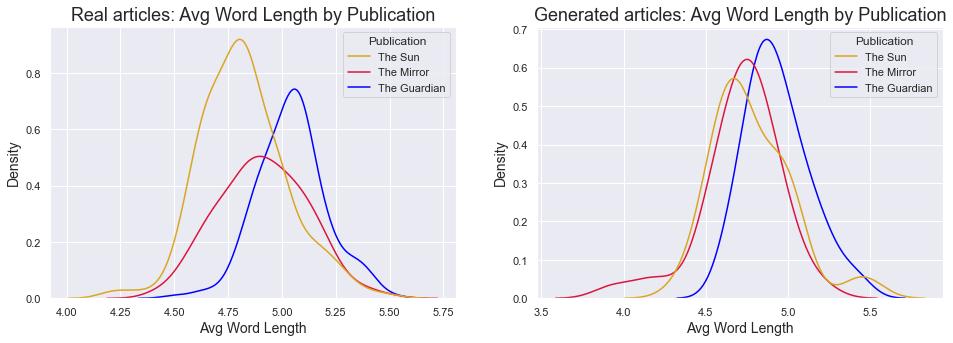

In [34]:
typeKDEpub(art, 'Avg Word Length', 'Avg Word Length')

In [35]:
statisticalTests(art, 'Avg Word Length')

For The Sun data:
Real data is Gaussian: False
Generated data is Gaussian: False 

The Man-Whitney U test p-value is 0.05637151416191473
Results of the Man-Whitney U test indicate that Avg Word Length is not significantly different between the real and generated text. 

For The Mirror data:
Real data is Gaussian: True
Generated data is Gaussian: False 

The Man-Whitney U test p-value is 1.7442662246133597e-06
Results of the Man-Whitney U test indicate that Avg Word Length is significantly different between the real and generated text. 

For The Guardian data:
Real data is Gaussian: True
Generated data is Gaussian: True 

The z-test p-value is 0.00017597495476593474
Results of the z-test indicate that Avg Word Length is significantly different between the real and generated text. 



The Mann-Whitney U test indicated the Sun model replicated word length within Sun generated articles - just about. The p-value is quite close to the alpha value (0.05), and the other two models created generated data with significantly different word length distributions. For the Mirror and the Guardian, the generated data modal word length was smaller than the real data, suggesting GPT-2 might tend to using smaller, less complex words in text generation. 

GPT-2 was trained on outgoing Reddit links which had been upliked by Reddit users [6]. Because of the source and the metric of popularity, it is likely most of the text in these outlinks was written in a common, everyday lexicon without too much complicated jargon or specialist language. It could be the case that GPT-2 has learned to construct sentences and grammar with simpler language than is contained in the Mirror and Guardian. 

### 6.3.4 Exploring interactions between length features

I wanted to explore the length features in relation to one another. It can be the case that a datapoint has a feature values within the normal range for those features, but the combination is an outlier. I also wanted to plot the length features together to see if there was any clustering visible, and if generated data replicated this.

I used plotly to plot the following interactive 3D charts. By rotating the below chart, we can see that the real articles do appear to form clusters (in a layer formation, with a good deal of overlap) on a plot of our three length features:

In [54]:
fig = px.scatter_3d(art[art['Type']=='Real'], x='Avg Word Length', y='Avg Sentence Length', z='Text Length',
              color='Publication', opacity=0.45, title='Real Articles')
fig.show()

*Image of the 3D plot:*
<img src="Images/image_1.png" align="left"/>

If we look at the length feature plot of the generated articles, we can see that they do appear to replicate the 'layer' clustering of the real articles:

In [55]:
fig = px.scatter_3d(art[art['Type']=='Generated'], x='Avg Word Length', y='Avg Sentence Length', z='Text Length',
              color='Publication', opacity=0.5, title='Generated Articles')
fig.show()

*Image of the 3D plot:*
<img src="Images/image_2.png" align="left"/>

I decided to plot each publication individually, so we could directly see how the generated articles compared to the real articles for each group, and spot any outliers:

In [56]:
fig = px.scatter_3d(art[art['Publication']=='The Sun'], x='Avg Word Length', y='Avg Sentence Length', z='Text Length',
              color='Type', opacity=0.5, title='The Sun')
fig.show()

*Image of the 3D plot:*
<img src="Images/image_3.png" align="left"/>

For the Sun, we can see that the generated articles generally fit within the real data cluster very well, with no obvious outliers. However, it becomes obvious on this plot that generated articles tend to shorter text length and average sentence length quite significantly.

In [57]:
fig = px.scatter_3d(art[art['Publication']=='The Mirror'], x='Avg Word Length', y='Avg Sentence Length', z='Text Length',
              color='Type', opacity=0.5, title='The Mirror')
fig.show()

*Image of the 3D plot:*
<img src="Images/image_4.png" align="left"/>

The Mirror plot lets us spot some obvious discrepancies between the real and generated data clusters. One of the most populace parts of the real data cluster (high avg sentence length, high avg word length, medium text length) is barely populated at all by generated datapoints, which tend to cluster in the low avg sentence length, low avg word length corner. Generated datapoints which are text length outliers (text length < 150) also tend to be avg word length outliers (avg word length < 4.3).

In [58]:
fig = px.scatter_3d(art[art['Publication']=='The Guardian'], x='Avg Word Length', y='Avg Sentence Length', z='Text Length',
              color='Type', opacity=0.5)
fig.show()

*Image of the 3D plot:*
<img src="Images/image_5.png" align="left"/>

The Guardian generated data appears to fit the real data cluster better than the Mirror data, however, we still see areas of the real data cluster which are densely populated with generated datapoints, and others which are sparsely populated, rather than an even distribution, or a distribution which mimics the real datapoint distribution throughout the space. We can again see a number of low Text Length outliers, and that these datapoints also tend to have a low average sentence length.

## 6.4 Measures of word choice

### 6.4.1 Creating features

We will be looking at the following:

* Type-Token Ratio
* Part-of-speech usage
* Key person mentions (named entity recognition)
* Hedge words
* Percentage of novel tokens

All of these will involve tokenising text, so we will create the features all at once to avoid having to tokenise text five times over. We will tokenise using spaCy, as we will be using the spaCy library for part-of-speech tagging.

**spaCy**

We will use the spaCy library rather than NLTK for part-of-speech tagging because NLTK's tags are far more numerous and complex than we require - there are 35 of them. spaCy has only 19 tags, and they are a lot simpler to interpret. In addition, we can do named entity recognition with spaCy with minimal additonal processing of the data. 

**Hedge words**

Hedge words are words such as 'could', 'possibly', 'might', which usually work to reduce the certainty of the statement it is attached to. It is a form of politeness in the sense that the speaker aknowledges they may be incorrect in their assumptions about the topic in question, e.g. 'This scandal will end his political career' vs 'This scandal will potentially end his political career'.

I could not find a ready to use corpus of hedging words for python, therefore I put together my own from two sources: a general reference list online [17], and a package of hedge words compiled for javascript [18]. A small proportion of these hedge words are actually hedge terms with multiple words, such as  "if I'm understanding you correctly". For simplicity, I chose to focus only on single hedge words.

It should be noted that one limitation of measuring hedge words is that if an author tends to use a lot of quotes in their articles, the source of hedging words might be quotes rather than the author's words themselves. 

We need to compile a list of hedge words:

In [98]:
hedge_lst = []

hedge_1 = open('hedge_words_list_1.txt', 'r', encoding='utf-8')
h1_lines = hedge_1.readlines()

for i in range(0, len(h1_lines)):
    line = h1_lines[i].strip()
    if len(line.split(' ')) == 1:
        hedge_lst.append(line)

hedge_2 = open('hedge_words_list_2.txt', 'r', encoding='utf-8')
h2_lines = hedge_2.readlines()

for i in range(0, len(h2_lines)):
    line = h2_lines[i].strip().rstrip("',").lstrip("'")
    if len(line.split(' ')) == 1:
        hedge_lst.append(line)

hedge_words = set(hedge_lst)
        
print(hedge_words)

{'little', 'couple', 'considers', 'guesses', 'perhaps', 'roughly', 'believe', 'believes', 'speculate', 'unsure', 'often', 'appeared', 'practically', 'most', 'surely', 'think', 'assumed', 'suppose', 'inconclusive', 'like', 'someone', 'almost', 'about', 'somewhere', 'clear', 'alleged', 'finds', 'likely', 'really', 'estimate', 'apparently', 'conceivably', 'speculates', 'say', 'speculated', 'rather', 'found', 'suggested', 'find', 'assume', 'says', 'possibly', 'guess', 'might', 'occasionally', 'estimates', 'unlikely', 'doubtful', 'pretty', 'could', 'certain', 'apparent', 'partially', 'around', 'definitely', 'seem', 'mostly', 'will', 'understood', 'somehow', 'mainly', 'generally', 'frequently', 'somebody', 'possible', 'quite', 'bunch', 'overall', 'allege', 'should', 'estimated', 'can', 'doubt', 'something', 'considered', 'possibility', 'guessed', 'fairly', 'thought', 'some', 'several', 'indicate', 'presumable', 'necessarily', 'supposedly', 'must', 'seemed', 'assumption', 'thinks', 'basically

Now we can get on with creating the rest of our features:

In [201]:
# Dataframe for storing proportion of tokens for each tag type per article
pos_tags = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'SPACE']

art_pos = art[['Type', 'Publication']]

for pos in pos_tags:
    art_pos.insert(len(art_pos.columns), pos, 0)

In [202]:
# Dataframe for storing set of unique tokens for each article - to be used for proportion of novel token calculations
art_ts = art[['Type', 'Publication']]
art_ts.insert(len(art_ts.columns), 'Token set', '')

In [203]:
# Dataframe to store named entities and count of mention for each article
art_ne = art[['Type', 'Publication']]
named_ents = []

In [128]:
art.insert(len(art.columns), 'Type-Token Ratio', 0)
art.insert(len(art.columns), 'Hedge Words per 1000 words', 0)

In [129]:
# If you get an error about 'en_core_web_sm', run in cmd: python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

In [204]:
for i in art.index:
    # Process text into spaCy Doc 
    doc = nlp(art['Text'][i])
    
    # Get list of all tokens
    token_lst = [token.text.lower() for token in doc]
    
    art_ts.at[i, 'Token set'] = set(token_lst)
    
    # Get a list of words
    word_lst = [token.text.lower() for token in doc if token.pos_ not in ['PART', 'PUNCT', 'SYM', 'SPACE']]
    
    art.loc[i, ['Type-Token Ratio']] = round(len(set(token_lst))/len(token_lst), 2)
    
    # Get all hedge words in text
    HW_in_text = [word for word in token_lst if word in hedge_words]
    art.loc[i, ['Hedge Words per 1000 words']] = round((len(HW_in_text)/len(word_lst))*1000, 2)
    
    # Get count of how many tokens fall into each POS category in the text
    pos_counts = doc.count_by(spacy.attrs.POS)

    for n_pos_tag, pos_count in pos_counts.items():
        pos_tag = doc.vocab[n_pos_tag].text
        
        # Calculate percentage of tokens of this type and add to art_pos dataframe
        art_pos.loc[i, [pos_tag]] = (pos_count/len(token_lst))*100
        
    # Named entity recognition
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            if ent.text not in named_ents:
                # Add column if it doesn't exist
                art_ne.insert(len(art_ne.columns), ent.text, 1)
                named_ents.append(ent.text)
            else:
                # Increase count of mentions of entity in text
                art_ne.loc[i, [ent.text]] += 1    

C:\Users\Masters\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\Masters\anaconda3\lib\site-packages\pandas\core\indexing.py:1700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


In [230]:
art.insert(len(art.columns), 'Percentage of novel tokens', 0)

In [236]:
real_ts = art_ts[art_ts['Type']=='Real']

for pub in real_ts['Publication'].unique():
    p_ts = real_ts[real_ts['Publication']==pub]
    for i in p_ts.index:
        
        # Get set of all other tokens which appear in other articles
        other_ts = set([])
        
        for r in p_ts.index:
            if r != i:
                other_ts.update(p_ts['Token set'][r])
                
        # Get all novel tokens
        ts = p_ts['Token set'][i]
        
        novel_tokens = [token for token in ts if token not in other_ts]
        
        art.loc[i, ['Percentage of novel tokens']] = round((len(novel_tokens)/len(ts))*100, 1)
                

In [238]:
gen_ts = art_ts[art_ts['Type']=='Generated']

for pub in gen_ts['Publication'].unique():
    
    gp_ts = gen_ts[gen_ts['Publication']==pub]
    rp_ts = real_ts[real_ts['Publication']==pub]
    
    real_art_ts = set([])
    
    for r in rp_ts.index:
        real_art_ts.update(rp_ts['Token set'][r])
    
    for i in gp_ts.index:
        
        ts = gp_ts['Token set'][i]
        
        novel_tokens = [token for token in ts if token not in real_art_ts]
        
        art.loc[i, ['Percentage of novel tokens']] = round((len(novel_tokens)/len(ts))*100, 1)

### 6.4.2 Word diversity: Type-Token Ratio

Type-Token Ratio is the number of unique tokens divided by the total number of tokens.

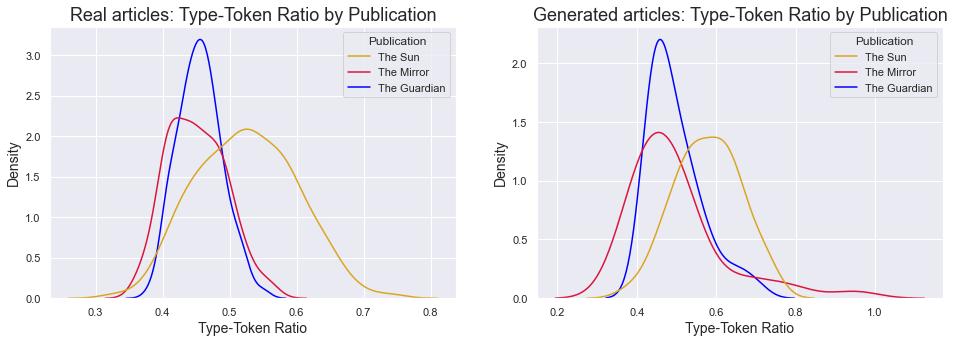

In [146]:
typeKDEpub(art, 'Type-Token Ratio', 'Type-Token Ratio')

Although the shapes of the distribution look quite similar between the real and generated data, the Mirror and the Guardian have substantially different spread (range) between real and generated data, which is information we will pass to the `statisticalTests` function as a non-parametric test should be used in this case.

In [39]:
statisticalTests(art, 'Type-Token Ratio', USM=True, USG=True)

For The Sun data:
Real data is Gaussian: True
Generated data is Gaussian: True 

The z-test p-value is 4.14238433208253e-05
Results of the z-test indicate that Type-Token Ratio is significantly different between the real and generated text. 

For The Mirror data:
Real data is Gaussian: False
Generated data is Gaussian: False 

Not using parametric test as unequal spread indicated. 

The Man-Whitney U test p-value is 0.006828662204789935
Results of the Man-Whitney U test indicate that Type-Token Ratio is significantly different between the real and generated text. 

For The Guardian data:
Real data is Gaussian: True
Generated data is Gaussian: False 

Not using parametric test as unequal spread indicated. 

The Man-Whitney U test p-value is 1.4915748357233587e-05
Results of the Man-Whitney U test indicate that Type-Token Ratio is significantly different between the real and generated text. 



From the statistical tests, we can infer that GPT-2 did not replicate the type-token ratios of the real articles. In particular, in the Mirror generated articles, we appear to have some outliers with very high type-token ratios which are skewing the distribution. As a whole, generated articles have a higher type-token ratio which could be being caused by the high temperature (1.0) parameter set for text generation, which controls how much randomness there is in the word generation.

### 6.4.3 Part-of-speech usage

We now have a dataframe, art_pos, which for every article records the percentage of tokens which belong to each different part-of-speech. Let's look at the means of these percentages for the real and generated article:

In [247]:
for col in pos_tags:
    print(col, 'mean:', round(art_pos[col].sum()/len(art_pos), 2))
    r_pos = art_pos[art_pos['Type']=='Real']
    g_pos = art_pos[art_pos['Type']=='Generated']
    print('Real article mean:', round(r_pos[col].sum()/len(r_pos), 2), '\nGenerated article mean:', round(g_pos[col].sum()/len(g_pos), 2), '\n')

ADJ mean: 6.39
Real article mean: 6.39 
Generated article mean: 6.39 

ADP mean: 10.43
Real article mean: 10.51 
Generated article mean: 9.96 

ADV mean: 3.15
Real article mean: 3.14 
Generated article mean: 3.19 

AUX mean: 6.03
Real article mean: 5.93 
Generated article mean: 6.64 

CONJ mean: 0.0
Real article mean: 0.0 
Generated article mean: 0.0 

CCONJ mean: 2.55
Real article mean: 2.56 
Generated article mean: 2.51 

DET mean: 8.54
Real article mean: 8.46 
Generated article mean: 9.07 

INTJ mean: 0.03
Real article mean: 0.03 
Generated article mean: 0.03 

NOUN mean: 18.59
Real article mean: 18.72 
Generated article mean: 17.76 

NUM mean: 1.38
Real article mean: 1.44 
Generated article mean: 1.02 

PART mean: 3.46
Real article mean: 3.4 
Generated article mean: 3.82 

PRON mean: 5.53
Real article mean: 5.44 
Generated article mean: 6.11 

PROPN mean: 8.73
Real article mean: 8.92 
Generated article mean: 7.6 

PUNCT mean: 11.24
Real article mean: 11.17 
Generated article mean: 

In general, part-of-speech proportion seems to be replicated pretty well in generated articles. Let's look at three important part-of-speech categories: nouns, verbs, and punctuation.

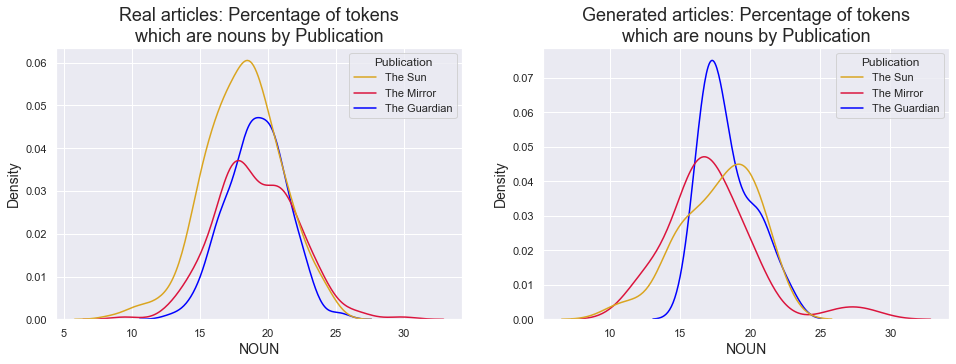

In [243]:
typeKDEpub(art_pos, 'NOUN', 'Percentage of tokens\nwhich are nouns')

In [244]:
statisticalTests(art_pos, 'NOUN')

For The Sun data:
Real data is Gaussian: True
Generated data is Gaussian: True 

The z-test p-value is 0.357847025380987
Results of the z-test indicate that NOUN is not significantly different between the real and generated text. 

For The Mirror data:
Real data is Gaussian: True
Generated data is Gaussian: False 

The Man-Whitney U test p-value is 1.5625307860509797e-05
Results of the Man-Whitney U test indicate that NOUN is significantly different between the real and generated text. 

For The Guardian data:
Real data is Gaussian: True
Generated data is Gaussian: False 

The Man-Whitney U test p-value is 0.007613107020351428
Results of the Man-Whitney U test indicate that NOUN is significantly different between the real and generated text. 



In [276]:
onewayANOVA(art_pos, 'NOUN', 'Real')

The Levene's test p-value is 0.00010252900956918715
Results of the test indicate that for NOUN  there is a significant difference between the variances of the text of the publications for Real data. Assumptions for the one-way ANOVA are violated. Proceed with Kruskal-Wallis instead.

The Kruskal-Wallis test p-value is 3.238639700683523e-05
Results of the Kruskal-Wallis test indicate that NOUN is significantly different between the text of the publications for Real data.



In [279]:
kruskalWallis(art_pos, 'NOUN', 'Generated')

The Kruskal-Wallis test p-value is 0.029463715402361527
Results of the Kruskal-Wallis test indicate that NOUN is significantly different between the text of the publications for Generated data.



Interestingly, when we start looking at the distribution of nouns in detail, on the whole the distribution is not replicated to a statistically significant degree. 

Let's look at verbs:

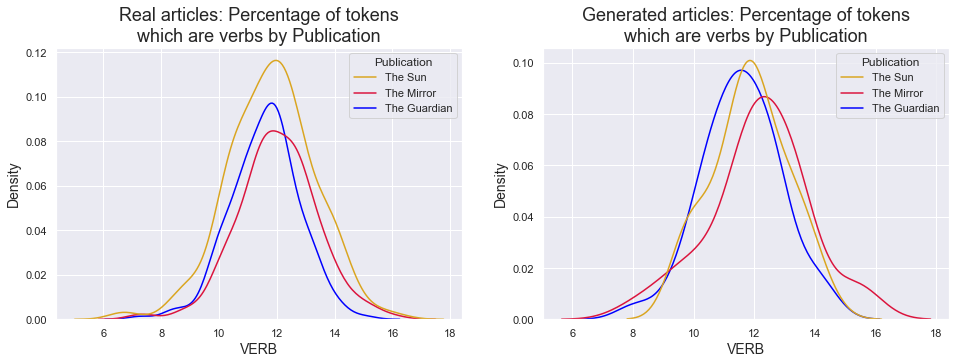

In [248]:
typeKDEpub(art_pos, 'VERB', 'Percentage of tokens\nwhich are verbs')

In [249]:
statisticalTests(art_pos, 'VERB')

For The Sun data:
Real data is Gaussian: True
Generated data is Gaussian: True 

The z-test p-value is 0.8882615181009876
Results of the z-test indicate that VERB is not significantly different between the real and generated text. 

For The Mirror data:
Real data is Gaussian: True
Generated data is Gaussian: True 

The z-test p-value is 0.5923240464643651
Results of the z-test indicate that VERB is not significantly different between the real and generated text. 

For The Guardian data:
Real data is Gaussian: True
Generated data is Gaussian: True 

The z-test p-value is 0.9142462081377379
Results of the z-test indicate that VERB is not significantly different between the real and generated text. 



In [277]:
onewayANOVA(art_pos, 'VERB', 'Real')

The Levene's test p-value is 0.002343476721340022
Results of the test indicate that for VERB  there is a significant difference between the variances of the text of the publications for Real data. Assumptions for the one-way ANOVA are violated. Proceed with Kruskal-Wallis instead.

The Kruskal-Wallis test p-value is 0.0036956674157489966
Results of the Kruskal-Wallis test indicate that VERB is significantly different between the text of the publications for Real data.



In [278]:
onewayANOVA(art_pos, 'VERB', 'Generated')

The Levene's test p-value is 0.43999504310049464
Results of the test indicate that for VERB  there is not a significant difference between the variances of the text of the publications for Generated data. We can proceed with the one-way ANOVA.

The one-way ANOVA p-value is 0.17674121772283138
Results of the one-way ANOVA indicate that VERB is not significantly different between the text of the publications for Generated data.



Interestingly, the models do replicate the distribution of verbs within generated text, and even though the Kruskal-Wallis indicated the real distributions were statistically different, but the ANOVA indicated the generated distributions are statistically the same. This may be down to the generated data having a much smaller sample size.

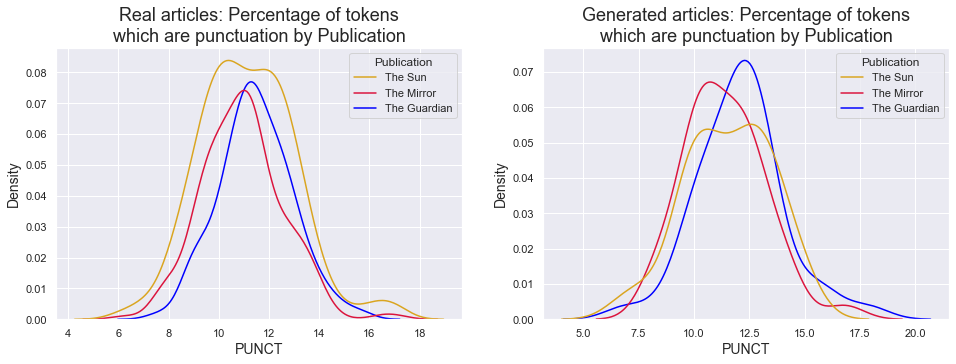

In [250]:
typeKDEpub(art_pos, 'PUNCT', 'Percentage of tokens\nwhich are punctuation')

In [251]:
statisticalTests(art_pos, 'PUNCT')

For The Sun data:
Real data is Gaussian: False
Generated data is Gaussian: True 

The Man-Whitney U test p-value is 0.059530690847543644
Results of the Man-Whitney U test indicate that PUNCT is not significantly different between the real and generated text. 

For The Mirror data:
Real data is Gaussian: False
Generated data is Gaussian: True 

The Man-Whitney U test p-value is 0.09379978460855942
Results of the Man-Whitney U test indicate that PUNCT is not significantly different between the real and generated text. 

For The Guardian data:
Real data is Gaussian: True
Generated data is Gaussian: True 

The z-test p-value is 0.01907344475650788
Results of the z-test indicate that PUNCT is significantly different between the real and generated text. 



In [281]:
kruskalWallis(art_pos, 'PUNCT', 'Real')

The Kruskal-Wallis test p-value is 0.001716845136793559
Results of the Kruskal-Wallis test indicate that PUNCT is significantly different between the text of the publications for Real data.



In [280]:
onewayANOVA(art_pos, 'PUNCT', 'Generated')

The Levene's test p-value is 0.655188472210497
Results of the test indicate that for PUNCT  there is not a significant difference between the variances of the text of the publications for Generated data. We can proceed with the one-way ANOVA.

The one-way ANOVA p-value is 0.22662808259372347
Results of the one-way ANOVA indicate that PUNCT is not significantly different between the text of the publications for Generated data.



A mixed bag for punctuation: two of the models generated a statistically similar distribution in the generated text. As with the verbs, the Kruskal-Wallis indicated the real distributions were statistically different, but the ANOVA indicated the generated distributions are statistically the same, making these results difficult to interpret.

### 6.4.4 Hedge words

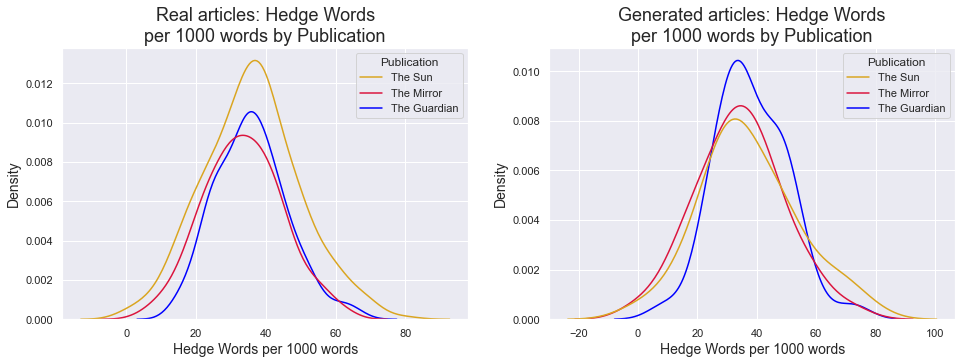

In [148]:
typeKDEpub(art, 'Hedge Words per 1000 words', 'Hedge Words\nper 1000 words')

In [149]:
statisticalTests(art, 'Hedge Words per 1000 words')

For The Sun data:
Real data is Gaussian: True
Generated data is Gaussian: True 

The z-test p-value is 0.5591482291418386
Results of the z-test indicate that Hedge Words per 1000 words is not significantly different between the real and generated text. 

For The Mirror data:
Real data is Gaussian: True
Generated data is Gaussian: True 

The z-test p-value is 0.687857166489088
Results of the z-test indicate that Hedge Words per 1000 words is not significantly different between the real and generated text. 

For The Guardian data:
Real data is Gaussian: False
Generated data is Gaussian: True 

The Man-Whitney U test p-value is 0.13226566103245457
Results of the Man-Whitney U test indicate that Hedge Words per 1000 words is not significantly different between the real and generated text. 



In [282]:
kruskalWallis(art, 'Hedge Words per 1000 words', 'Real')

The Kruskal-Wallis test p-value is 0.05717154977484182
Results of the Kruskal-Wallis test indicate that Hedge Words per 1000 words is not significantly different between the text of the publications for Real data.



In [283]:
onewayANOVA(art, 'Hedge Words per 1000 words', 'Generated')

The Levene's test p-value is 0.27349879251647324
Results of the test indicate that for Hedge Words per 1000 words  there is not a significant difference between the variances of the text of the publications for Generated data. We can proceed with the one-way ANOVA.

The one-way ANOVA p-value is 0.458088421862372
Results of the one-way ANOVA indicate that Hedge Words per 1000 words is not significantly different between the text of the publications for Generated data.



Statistically, all the articles had the same distribution. 

### 6.4.5 Key persons mentioned (named entity recognition)

We added a column for every unique named entity spaCy tagged as a person in our articles:

In [163]:
named_persons = art_ne.columns.tolist()[2:]

len(named_persons)

1793

That's a lot of people mentioned! Let's have a look who the most mentioned people were in every category:

In [208]:
for pub in art_ne['Publication'].unique():
    
    p_ne = art_ne[art_ne['Publication']==pub]
    
    for atype in p_ne['Type'].unique():
        
        t_ne = p_ne[p_ne['Type']==atype]
        
        # Get most commonly named entities for this type and publication
        top_ne = pd.DataFrame(columns=['Entity', 'Total mentions', 'Mentions per article'])
        
        for ne in named_persons:
            top_ne = top_ne.append({'Entity': ne, 'Total mentions': t_ne[ne].sum(),
                                   'Mentions per article': t_ne[ne].sum()/len(t_ne)}, ignore_index=True)
        
        top_ne.sort_values('Total mentions', ascending=False, inplace=True)
        
        print('The top named entities for', atype, pub, 'articles are:\n', top_ne[:10], '\n')

The top named entities for Real The Sun articles are:
             Entity Total mentions  Mentions per article
8          Johnson            569              1.750769
70           Covid            451              1.387692
2    Boris Johnson            444              1.366154
25   BORIS Johnson            401              1.233846
45          Brexit            396              1.218462
12      Mr Johnson            371              1.141538
14           Boris            367              1.129231
101    Rishi Sunak            357              1.098462
60            Keir            353              1.086154
37    Keir Starmer            353              1.086154 

The top named entities for Generated The Sun articles are:
             Entity Total mentions  Mentions per article
8          Johnson             63                 1.575
70           Covid             46                 1.150
2    Boris Johnson             45                 1.125
37    Keir Starmer             44          

There are some interesting insights here. Firstly, spaCy thinks Covid and Brexit are people. Secondly, at first glance, GPT-2 seems to do a pretty good job at mentioning people who were mentioned in real articles. 

Boris Johnson is the only person named often enough for us to do an analysis of mention distribution for - but first we will need to create a single 'Boris Johnson mention' score combining all the different entity terms used to reference him. Even BoJo makes an appearance:

In [174]:
'BoJo' in named_persons

True

In [184]:
boris_cols = ['Boris Johnson', 'Boris', 'Johnson', "Boris Johnson's", 'BORIS Johnson', "BORIS Johnson's", 'BoJo']

In [254]:
art.insert(len(art.columns), 'Boris mentions per 1000 words', 0)

In [288]:
for i in art.index:
    boris_count = 0
    
    for boris in boris_cols:
        boris_count += art_ne[boris][i]
    
    art.loc[i, 'Boris mentions per 1000 words'] = (boris_count/art['Text Length'][i])*1000

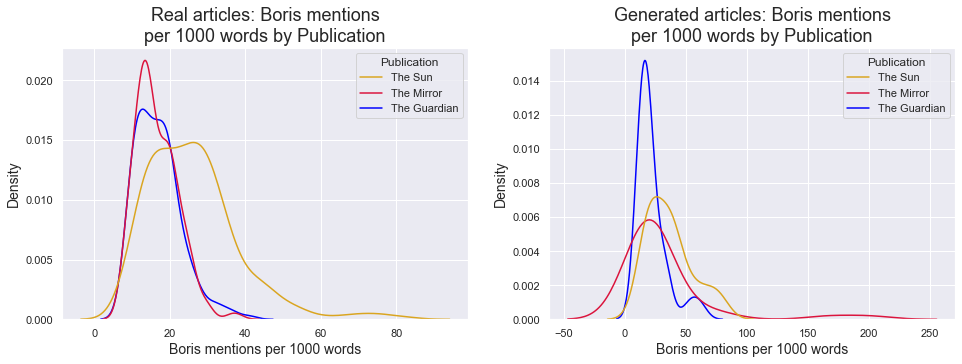

In [289]:
typeKDEpub(art, 'Boris mentions per 1000 words', 'Boris mentions\nper 1000 words')

In [290]:
statisticalTests(art, 'Boris mentions per 1000 words', USM=True, USG=True)

For The Sun data:
Real data is Gaussian: False
Generated data is Gaussian: False 

The Man-Whitney U test p-value is 0.0002556385634730791
Results of the Man-Whitney U test indicate that Boris mentions per 1000 words is significantly different between the real and generated text. 

For The Mirror data:
Real data is Gaussian: False
Generated data is Gaussian: False 

Not using parametric test as unequal spread indicated. 

The Man-Whitney U test p-value is 0.000367267583952655
Results of the Man-Whitney U test indicate that Boris mentions per 1000 words is significantly different between the real and generated text. 

For The Guardian data:
Real data is Gaussian: False
Generated data is Gaussian: False 

Not using parametric test as unequal spread indicated. 

The Man-Whitney U test p-value is 0.015158229429909473
Results of the Man-Whitney U test indicate that Boris mentions per 1000 words is significantly different between the real and generated text. 



Unsurpringly from looking at the KDEplots, the statistical tests indicated the distributions in the generated articles were not the same as the real articles. 

Let's plot this feature on a different graph to explore how the distributions are different further:

[Text(0.5, 1.0, 'Generated articles')]

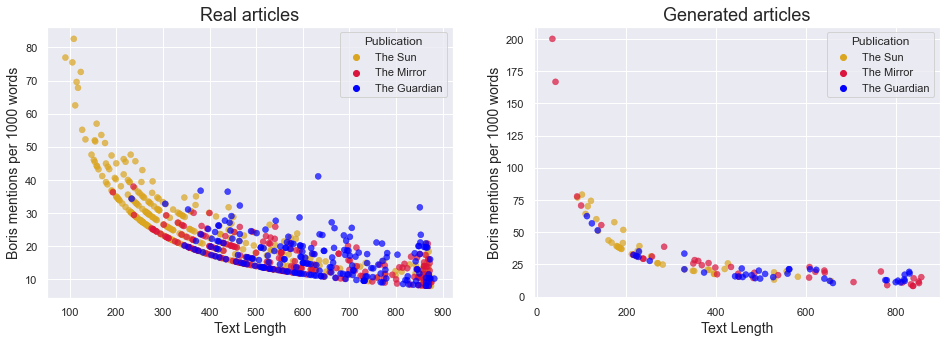

In [300]:
plt.figure(figsize=(16,5))
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18

plt.subplot(1,2,1)
ax = sns.scatterplot(data = art[art['Type']=='Real'], x = 'Text Length', y = 'Boris mentions per 1000 words',  
                 hue = 'Publication', palette=pub_palette, legend=True, alpha = 0.7, edgecolor=None)
ax.set(title='Real articles')

plt.subplot(1,2,2)
ax = sns.scatterplot(data = art[art['Type']=='Generated'], x = 'Text Length', y = 'Boris mentions per 1000 words',  
                 hue = 'Publication', palette=pub_palette, legend=True, alpha = 0.7, edgecolor=None)
ax.set(title='Generated articles')

We can see two substancial outliers which are obscuring the generated data. Let's plot again without the outliers:

[Text(0.5, 1.0, 'Generated articles without outliers')]

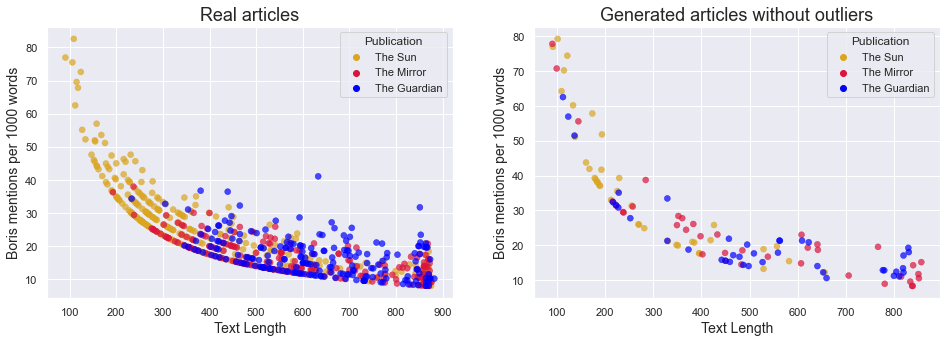

In [307]:
# Remove outliers and plot again
art_woo = art[art['Boris mentions per 1000 words'] < 100]

plt.figure(figsize=(16,5))
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18

plt.subplot(1,2,1)
ax = sns.scatterplot(data = art[art['Type']=='Real'], x = 'Text Length', y = 'Boris mentions per 1000 words',  
                 hue = 'Publication', palette=pub_palette, legend=True, alpha = 0.7, edgecolor=None)
ax.set(title='Real articles')

plt.subplot(1,2,2)
ax = sns.scatterplot(data = art_woo[art_woo['Type']=='Generated'], x = 'Text Length', y = 'Boris mentions per 1000 words',  
                 hue = 'Publication', palette=pub_palette, legend=True, alpha = 0.7, edgecolor=None)
ax.set(title='Generated articles without outliers')

We can see a clear trend of a logarithm like curve for all articles, with Boris mentions per 1000 words rapidly dropping as text length decreases. We can see that for the Mirror and Guardian in particular, generated articles having a generally lower text length than real ones means their distributions for Boris mentions, which follow the trend, are significantly different from real articles.

### 6.4.6 Percentage of novel tokens

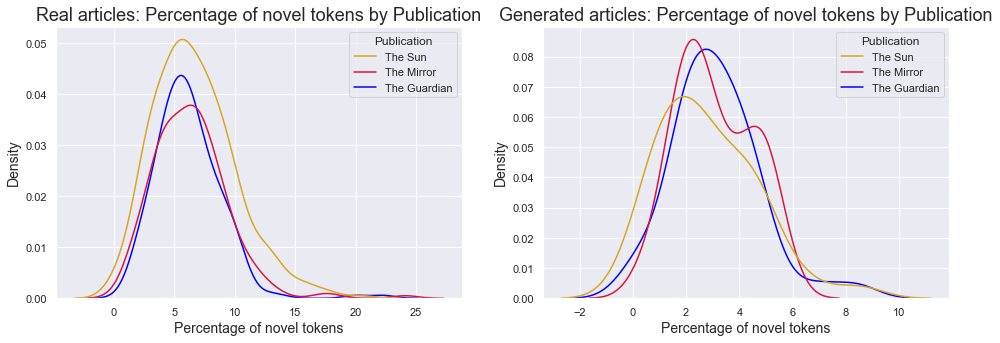

In [240]:
typeKDEpub(art, 'Percentage of novel tokens', 'Percentage of novel tokens')

In [241]:
statisticalTests(art, 'Percentage of novel tokens', USS=True, USM=True, USG=True)

For The Sun data:
Real data is Gaussian: False
Generated data is Gaussian: True 

Not using parametric test as unequal spread indicated. 

The Man-Whitney U test p-value is 3.0588477337041697e-13
Results of the Man-Whitney U test indicate that Percentage of novel tokens is significantly different between the real and generated text. 

For The Mirror data:
Real data is Gaussian: False
Generated data is Gaussian: True 

Not using parametric test as unequal spread indicated. 

The Man-Whitney U test p-value is 3.469435063089077e-12
Results of the Man-Whitney U test indicate that Percentage of novel tokens is significantly different between the real and generated text. 

For The Guardian data:
Real data is Gaussian: False
Generated data is Gaussian: False 

Not using parametric test as unequal spread indicated. 

The Man-Whitney U test p-value is 6.146871605376958e-13
Results of the Man-Whitney U test indicate that Percentage of novel tokens is significantly different between the real and 

In [266]:
kruskalWallis(art, 'Percentage of novel tokens', 'Real')

The Kruskal-Wallis test p-value is 0.3006988970296677
Results of the Kruskal-Wallis test indicate that Percentage of novel tokens is not significantly different between the text of the publications for Real data.



In [267]:
kruskalWallis(art, 'Percentage of novel tokens', 'Generated')

The Kruskal-Wallis test p-value is 0.4989537802951134
Results of the Kruskal-Wallis test indicate that Percentage of novel tokens is not significantly different between the text of the publications for Generated data.



Generated articles share the same distribution, real articles share the same distribution, but generated articles do not have the same distribution as real articles. In fact, generated articles tend to have a substantically lower percentage of novel tokens compared to real articles. This is contasted with our findings that generated articles tend to have a higher type-token ratio.

Let's plot these two features:

[Text(0.5, 1.0, 'Generated articles')]

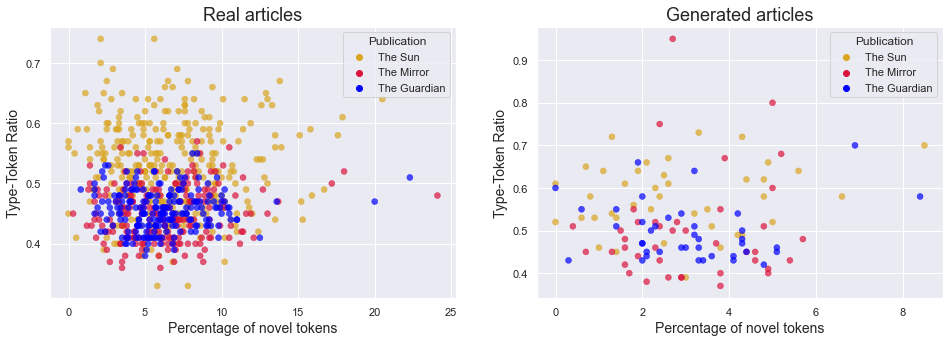

In [318]:
plt.figure(figsize=(16,5))
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18

plt.subplot(1,2,1)
ax = sns.scatterplot(data = art[art['Type']=='Real'], x = 'Percentage of novel tokens', y = 'Type-Token Ratio',  
                 hue = 'Publication', palette=pub_palette, legend=True, alpha = 0.7, edgecolor=None)
ax.set(title='Real articles')

plt.subplot(1,2,2)
ax = sns.scatterplot(data = art[art['Type']=='Generated'], x = 'Percentage of novel tokens', y = 'Type-Token Ratio',  
                 hue = 'Publication', palette=pub_palette, legend=True, alpha = 0.7, edgecolor=None)
ax.set(title='Generated articles')

There is no obvious correlation here. These results make sense when we think about the way articles of both types are created. Writers tend to focus on one topic (or a couple of closely related ones), while generated text, especially long-form generated text, is notiorious for switching between topics and deviating in direction (lack of coherence and cohesion problem [10]). It therefore makes sense that generated text would have a higher type-token ratio than human-written text. In addition, when authors write about a single cohesive topic or event, they tend to bring in detail and specialist language related to that topic, creating a relatively high percentage of novel tokens. In contrast, the model generating data mainly copies from what it has already seen, with an element of randomness included.

# 7 Conclusion <a class="anchor" id="conc"></a>

## 7.1 Summary of outcomes

At the beginning of the project, I stated my aim as exploring how closely the text generated by a fine-tuned GPT-2 model replicates the distribution of stylistic features of fine-tune training text.

My objectives were to:

1. Scrape, clean and prepare training data in a format which is suitable for fine-tuning GPT-2
2. Fine-tune GPT-2 and generate a sufficent amount of text for analysis
3. Clean and prepare the generated text for analysis
4. Calculate stylistic features from the data
5. Analyse the data through visualisations and statistical methods

I believe I have achieved all these objectives. Reflecting on the aim itself, while I have technically achieved what I set out to do, my findings often created further questions, and have ultimately made me critically reflect on my approach overall.

## 7.2 Summary of findings

I consider the following the most significant and interesting findings and reflections:

* Often generated data distributions reflected real data distributions in shape, but from a statistical point of view did not have the same distribution. Examples of this are text length, average sentence length and average word length.
* When looking at the interaction between length features, we saw that often generated datapoints sat within the real article cluster (with a few outliers), but they were primarily grouped in one *subsection* of the real article cluster. This could be due to the WebText GPT-2 was originally trained on causing it to tend to certain modes of making sentences and using words. It would be interesting to find a way to explore this in more detail.
* A datapoint having a low text length tended to cause the datapoint to be an outlier in other features also (in comparison to datapoints with higher text lengths).
* Looking at the complete real and generated datasets, as an average different parts-of-speech had the same proportions. However, this did not always mean real and generated data had the same distribitions for parts-of-speech, as shown by noun distribution.
* Generated articles had high token diversity (type-token ratio) but low proportion of novel tokens compared to real articles. This is likely because long-form generated text tends to switch topics and lack cohesion. This is a way in which coherence of text becomes an influence on style. This finding made me consider that coherence and cohesion of text should be a key consideration when it comes to assessing style.

## 7.3 Evaluation of approach

Style is a large topic, and inevitably there are gaps in my analysis.

In choosing to focus on word choice, I only minimally explored sentences and the structure of the document as a whole. It is, for example, possible to categorise sentences into Simple/Complex/Compound/Complex-Compound, etc. Feng et al. [19] in their 2012 paper 'Characterizing Stylistic Elements in Syntactic Structure' did this via algorithms based on tree topology, and showed this had some predictive power in author attribution tasks. However, like many other methods for analysing style, this approach is significantly more complex and time-consuming than the ones I have used here. For example, in this project I used hedge words as a proxy for politeness. Another element of style, formality, is much harder to measure: often, this is achieved by training a model to classify sentences as formal or not using formality corpora as training material [20]. Using machine learning to classify style is common trend: Feng et al. [16] fine-tuned BERT sentiment regressor to measure Sentiment Consistency. Training/fine-tuning is a time-consuming task even when training data is readily avaliable, but even more resource intensive for novel approaches, making text style a difficult area to explore in breadth and depth. 

Due to the text generation limit of 1023 tokens, which is shorter than many articles in my training corpora, I cut my real articles short to ensure analysis is as valid as possible. This created a limitation that I could not explore articles in sections. For example, features may present differently at the start, middle and end of a piece of writing as an author alters their pace to engage readers. 

Finally, I consider one of the biggest limitations of my approach to be the fact that it is divorced from the biggest focus in Natural Langauage Generation, coherence, which limits the utility of the work. Some work, like Tambwekar et al.'s [10] 2018 paper 'Controllable Neural Story Generation via Reinforcement Learning', focuses on training models to generate stories which have a cohesive and clear direction and narrative. An interesting research topic would be looking at the interaction of style and coherence in generated text, and how elements of style change as the coherence of generated text improves. 

# 8 References <a class="anchor" id="rr"></a>

[1] A. Das and R. M. Verma, "Can Machines Tell Stories? A Comparative Study of Deep Neural Language Models and Metrics," in IEEE Access, vol. 8, pp. 181258-181292, 2020, doi: 10.1109/ACCESS.2020.3023421.  
[2] https://minimaxir.com/2019/09/howto-gpt2/   
[3] Vaswani, Ashish, Noam M. Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser and Illia Polosukhin. “Attention is All you Need.” ArXiv abs/1706.03762 (2017)  
[4] A. Gillioz, J. Casas, E. Mugellini and O. A. Khaled, "Overview of the Transformer-based Models for NLP Tasks," 2020 15th Conference on Computer Science and Information Systems (FedCSIS), 2020, pp. 179-183, doi: 10.15439/2020F20.  
[5] Ziegler, Daniel M., Nisan Stiennon, Jeff Wu, Tom B. Brown, Alec Radford, Dario Amodei, Paul Christiano and Geoffrey Irving. “Fine-Tuning Language Models from Human Preferences.” ArXiv abs/1909.08593 (2019)  
[6] Radford, A., Wu, J., Child, R., Luan, D., Amodei, D., & Sutskever, I. (2019). Language Models are Unsupervised Multitask Learners.  
[7] M. Toshevska and S. Gievska, "A Review of Text Style Transfer using Deep Learning," in IEEE Transactions on Artificial Intelligence, doi: 10.1109/TAI.2021.3115992.  
[8] Tsai, Alicia Lishin, Shereen Oraby, Vittorio Perera, Jiun-Yu Kao, Yuheng Du, Anjali Narayan-Chen, Tagyoung Chung and Dilek Z. Hakkani-Tür. “Style Control for Schema-Guided Natural Language Generation.” ArXiv abs/2109.12211 (2021)   
[9] Lai, Huiyuan, Antonio Toral and Malvina Nissim. “Thank you BART! Rewarding Pre-Trained Models Improves Formality Style Transfer.” ACL/IJCNLP (2021).  
[10] Tambwekar, Pradyumna, Murtaza Dhuliawala, Animesh Mehta, Lara J. Martin, Brent Harrison and Mark O. Riedl. “Controllable Neural Story Generation via Reinforcement Learning.” ArXiv abs/1809.10736 (2018)  
[11] Gui, J., Sun, Z., Wen, Y., Tao, D., & Ye, J. (2021). A Review on Generative Adversarial Networks: 
Algorithms, Theory, and Applications. IEEE Transactions on Knowledge and Data Engineering  
[12] https://github.com/minimaxir/gpt-2-simple  
[13] https://medium.com/analytics-vidhya/understanding-the-gpt-2-source-code-part-1-4481328ee10b  
[14] Grace I. Lin and Marilyn A. Walker. "Stylistic Variation in Television Dialogue for Natural Language Generation" (2017)  
[15] Verma, Gaurav and Balaji Vasan Srinivasan. “A Lexical, Syntactic, and Semantic Perspective for Understanding Style in Text.” ArXiv abs/1909.08349 (2019)
[16] Feng, Steven Y., Varun Gangal, Dongyeop Kang, Teruko Mitamura and Eduard H. Hovy. “GenAug: Data Augmentation for Finetuning Text Generators.” ArXiv abs/2010.01794 (2020)   
[17] https://www.textcompare.org/readability/hedge-words    
[18] https://github.com/words/hedges   
[19] Song Feng, Ritwik Banerjee, and Yejin Choi. 2012. Characterizing stylistic elements in syntactic structure. In *Proceedings of the 2012 Joint Conference on Empirical Methods in Natural Language Processing and Computational Natural Language Learning (EMNLP-CoNLL '12)*. Association for Computational Linguistics, USA, 1522–1533.   
[20] Rao, Sudha and Joel R. Tetreault. “Dear Sir or Madam, May I Introduce the GYAFC Dataset: Corpus, Benchmarks and Metrics for Formality Style Transfer.” NAACL (2018).